<a href="https://colab.research.google.com/github/christopher-nones/Rumour-Evaluation-Keras-DL/blob/main/Rumour_Evaluation_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backgroud - RumourEval


[RumourEval 2019 Task 7 ](http://www.zubiaga.org/publications/files/rumoureval2019.pdf)was a challenge to produce a model that can determine the veracity of a comment in response to a rumour. This can be of class: comment, query, support or denial of the given rumour. 

This study aims to build a model **that can determine veracity in response to a rumour**. This notebook contains a modified version of the dataset from RumourEval 2019 - Task 7. The dataset contains labeled source and reply comments from Twitter and Reddit. 


As the the problem is defined as determining response veracity text to a source the model was built have both source and reply as inputs as it is logical that the veracity of a reply depends on the context of the source. 

*Alternatively the text from the four classes could have been classified irrespective of source, or the -1 class indicating source also be classified in a 5 class model. However, this approach is flawed as it is not following the logic of natural language and would likely result in a biased model.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ver 1.0

# Preamble

In [ ]:
#Packages CopyPasted From W5 lab
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import pathlib
import shutil
import tempfile

import re

from  IPython import display
from matplotlib import pyplot as plt

print("Tensorflow version is: ", tf.__version__)


Tensorflow version is:  2.6.0


In [ ]:
# Workbook constants

extraction_path = "./data/"


# Loading Data/Exploration


In [ ]:
!cp /content/drive/'My Drive'/COSC2779/Assignment2/Rumour_data.zip .
!unzip -q -o Rumour_data.zip

!rm Rumour_data.zip

# !unzip -q -o Images.zip

In [ ]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('./Rumour_data/twitter_dataset.csv')
dataset.head(5)

Type        Msg_ID  ...              Topic    Class
0  Source  5.810630e+17  ...  germanwings-crash       -1
1   Reply  5.810700e+17  ...  germanwings-crash    query
2   Reply  5.810640e+17  ...  germanwings-crash  comment
3  Source  5.813860e+17  ...  germanwings-crash       -1
4   Reply  5.815760e+17  ...  germanwings-crash  comment

[5 rows x 6 columns]

# Incorporating source into reply dataframe

In [ ]:
responses = dataset.iloc[0:0]
responses['Source_text'] = ""

SourceTxt = ""
for i, txt_type in enumerate(dataset['Type']):
  
  row = dataset.iloc[i]
  
  if txt_type == "Source":
    
    SourceTxt = dataset.iloc[i][3]
  if txt_type == "Reply":
    row.at['Source_text'] = SourceTxt
    responses = responses.append(row)

    
  
responses


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Type  ...                                        Source_text
1     Reply  ...  #4U9525: Robin names Andreas Lubitz as the cop...
2     Reply  ...  #4U9525: Robin names Andreas Lubitz as the cop...
4     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
5     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
6     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
...     ...  ...                                                ...
6629  Reply  ...  Here's how to deal with those clumps of floati...
6630  Reply  ...  Here's how to deal with those clumps of floati...
6631  Reply  ...  Here's how to deal with those clumps of floati...
6632  Reply  ...  Here's how to deal with those clumps of floati...
6633  Reply  ...  Here's how to deal with those clumps of floati...

[6253 rows x 7 columns]

It appears that using MSG ID cannot be used to match Source with Reply

In [ ]:
germanwings = dataset[dataset['Topic'] == "germanwings-crash"]

In [ ]:
test = dataset[dataset['Type'] == 'Source']
test['Msg_ID'].value_counts()

test[test['Msg_ID'] == 5.535870e+17  ]

Type        Msg_ID  ...         Topic Class
4404  Source  5.535870e+17  ...  charliehebdo    -1
4963  Source  5.535870e+17  ...  charliehebdo    -1
5089  Source  5.535870e+17  ...  charliehebdo    -1
5234  Source  5.535870e+17  ...  charliehebdo    -1

[4 rows x 6 columns]

In [ ]:
dataset[dataset['Source_Msg_ID'] == 5.535870e+17  ]

Type        Msg_ID  ...         Topic    Class
4405  Reply  5.535910e+17  ...  charliehebdo  support
4406  Reply  5.535910e+17  ...  charliehebdo  support
4407  Reply  5.535880e+17  ...  charliehebdo  comment
4408  Reply  5.535900e+17  ...  charliehebdo  comment
4409  Reply  5.535940e+17  ...  charliehebdo  comment
...     ...           ...  ...           ...      ...
5249  Reply  5.535870e+17  ...  charliehebdo  support
5250  Reply  5.535870e+17  ...  charliehebdo  comment
5251  Reply  5.535880e+17  ...  charliehebdo    query
5252  Reply  5.535870e+17  ...  charliehebdo  comment
5253  Reply  5.535870e+17  ...  charliehebdo  comment

[64 rows x 6 columns]

## Checking For Duplicates


In [ ]:
responses = responses[responses['Text'] != '[deleted]']
dataset = responses[responses['Text'] != '[removed]']

There are 4 instances of duplicate entries

In [ ]:
dataset = dataset.drop_duplicates()
dataset

Type  ...                                        Source_text
1     Reply  ...  #4U9525: Robin names Andreas Lubitz as the cop...
2     Reply  ...  #4U9525: Robin names Andreas Lubitz as the cop...
4     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
5     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
6     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
...     ...  ...                                                ...
6629  Reply  ...  Here's how to deal with those clumps of floati...
6630  Reply  ...  Here's how to deal with those clumps of floati...
6631  Reply  ...  Here's how to deal with those clumps of floati...
6632  Reply  ...  Here's how to deal with those clumps of floati...
6633  Reply  ...  Here's how to deal with those clumps of floati...

[6251 rows x 7 columns]

In [ ]:
duplicateRowsDF = dataset[dataset.duplicated('Text', keep = False)]
duplicateRowsDF.sort_values(['Msg_ID'], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)

duplicateRowsDF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Type  ...                                        Source_text
2090  Reply  ...  Every 28 hours a black male is killed in the U...
2076  Reply  ...  Every 28 hours a black male is killed in the U...
2079  Reply  ...  Every 28 hours a black male is killed in the U...
2065  Reply  ...  Every 28 hours a black male is killed in the U...
2062  Reply  ...  Every 28 hours a black male is killed in the U...
2074  Reply  ...  Every 28 hours a black male is killed in the U...
2088  Reply  ...  Every 28 hours a black male is killed in the U...
1518  Reply  ...  #BREAKING news: Shots fired at Parliament Hill...
1519  Reply  ...  #BREAKING news: Shots fired at Parliament Hill...
1509  Reply  ...  #BREAKING news: Shots fired at Parliament Hill...
1507  Reply  ...  #BREAKING news: Shots fired at Parliament Hill...
1533  Reply  ...  Recap: Gunman shot dead inside Parliament buil...
1738  Reply  ...  #RCMP to hold news conference on #Ottawa shoot...
1573  Reply  ...  #ISIS Media account posts picture claiming to ...
1575  Reply  ...  #ISIS Media account posts picture claiming to ...
1203  Reply  ...  Canadian authorities have given name of suspec...
1201  Reply  ...  Canadian authorities have given name of suspec...
3286  Reply  ...  Several more hostages flee from cafe under sie...
3718  Reply  ...  Police confirm that #sydneysiege is finally ov...
3726  Reply  ...  Police confirm that #sydneysiege is finally ov...
5128  Reply  ...  Rural region of northern France searched in hu...
4598  Reply  ...  Map shows industrial estate where 2 #CharlieHe...
5130  Reply  ...  Rural region of northern France searched in hu...
5383  Reply  ...  BREAKING: Police order all shops closed in fam...
5375  Reply  ...  BREAKING: Police order all shops closed in fam...
5385  Reply  ...  BREAKING: Police order all shops closed in fam...
5139  Reply  ...  Rural region of northern France searched in hu...
5141  Reply  ...  Rural region of northern France searched in hu...
366   Reply  ...  #Germanwings latest: http://t.co/8tZopIBYLh\n-...
829   Reply  ...  Anyone who knows Marina Joyce personally knows...
855   Reply  ...  Anyone who knows Marina Joyce personally knows...
975   Reply  ...  Anyone who knows Marina Joyce personally knows...
884   Reply  ...  Anyone who knows Marina Joyce personally knows...
830   Reply  ...  Anyone who knows Marina Joyce personally knows...
834   Reply  ...  Anyone who knows Marina Joyce personally knows...
6394  Reply  ...  Unreal\nRT@invisibleman_17\nBelieve it or not,...
6392  Reply  ...  Unreal\nRT@invisibleman_17\nBelieve it or not,...
6566  Reply  ...  Prince William and Harry donates $100 million ...
6560  Reply  ...  Prince William and Harry donates $100 million ...
5956  Reply  ...  "@KenyanTraffic: "National Geographic channel ...
5999  Reply  ...  "@KenyanTraffic: "National Geographic channel ...
5955  Reply  ...  "@KenyanTraffic: "National Geographic channel ...

[42 rows x 7 columns]

In [ ]:
dataset.drop_duplicates(subset = ["Text"], keep = "first", inplace = True)
dataset

Type  ...                                        Source_text
1     Reply  ...  #4U9525: Robin names Andreas Lubitz as the cop...
2     Reply  ...  #4U9525: Robin names Andreas Lubitz as the cop...
4     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
5     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
6     Reply  ...  RT @khjelmgaard: German media reporting #Andre...
...     ...  ...                                                ...
6629  Reply  ...  Here's how to deal with those clumps of floati...
6630  Reply  ...  Here's how to deal with those clumps of floati...
6631  Reply  ...  Here's how to deal with those clumps of floati...
6632  Reply  ...  Here's how to deal with those clumps of floati...
6633  Reply  ...  Here's how to deal with those clumps of floati...

[6224 rows x 7 columns]

In [ ]:
dataset[dataset.duplicated(subset = ['Text'])]

Empty DataFrame
Columns: [Type, Msg_ID, Source_Msg_ID, Text, Topic, Class, Source_text]
Index: []

In [ ]:
dataset2 = pd.read_csv('./Rumour_data/Extra_reddit_dataset.csv')
dataset2

Type   Msg_ID  ... Topic    Class
0     Source   63uefi  ...  None       -1
1      Reply  dfx7l1a  ...  None  comment
2      Reply  dfx88qg  ...  None  comment
3      Reply  dfx3i17  ...  None  comment
4      Reply  dfx4yef  ...  None  comment
...      ...      ...  ...   ...      ...
2466   Reply  e3bg540  ...  None  comment
2467   Reply  e3c6wgj  ...  None  comment
2468   Reply  e3cgyvc  ...  None  comment
2469   Reply  e3b7gdl  ...  None  comment
2470   Reply  e3bw3zg  ...  None  comment

[2471 rows x 6 columns]

In [ ]:
responses = dataset2.iloc[0:0]
responses['Source_text'] = ""

SourceTxt = ""
for i, txt_type in enumerate(dataset2['Type']):
  # print(i,text_type)
  row = dataset2.iloc[i]
  
  if txt_type == "Source":
    
    SourceTxt = dataset2.iloc[i][3]
  if txt_type == "Reply":
    row.at['Source_text'] = SourceTxt
    responses = responses.append(row)

    
  
responses


Type  ...                                        Source_text
1     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
2     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
3     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
4     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
5     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
...     ...  ...                                                ...
2466  Reply  ...  Iodine increases IQ and is an essential part o...
2467  Reply  ...  Iodine increases IQ and is an essential part o...
2468  Reply  ...  Iodine increases IQ and is an essential part o...
2469  Reply  ...  Iodine increases IQ and is an essential part o...
2470  Reply  ...  Iodine increases IQ and is an essential part o...

[2431 rows x 7 columns]

In [ ]:
dataset2.drop_duplicates(subset = ["Text"], keep = "first", inplace= True)
dataset2

Type   Msg_ID  ... Topic    Class
0     Source   63uefi  ...  None       -1
1      Reply  dfx7l1a  ...  None  comment
2      Reply  dfx88qg  ...  None  comment
3      Reply  dfx3i17  ...  None  comment
4      Reply  dfx4yef  ...  None  comment
...      ...      ...  ...   ...      ...
2452   Reply  e3bn1v6  ...  None  comment
2457   Reply  e3b5lyp  ...  None  comment
2459   Reply  e3b9yiy  ...  None  comment
2463   Reply  e3bsdee  ...  None  comment
2467   Reply  e3c6wgj  ...  None  comment

[1069 rows x 6 columns]

In [ ]:
#Remove entries with deleted and removed txt

responses = responses[responses['Text'] != '[deleted]']
dataset2 = responses[responses['Text'] != '[removed]']
dataset2

Type  ...                                        Source_text
1     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
2     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
4     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
5     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
6     Reply  ...  Donald Trump's travel expenses in 10 weeks cos...
...     ...  ...                                                ...
2466  Reply  ...  Iodine increases IQ and is an essential part o...
2467  Reply  ...  Iodine increases IQ and is an essential part o...
2468  Reply  ...  Iodine increases IQ and is an essential part o...
2469  Reply  ...  Iodine increases IQ and is an essential part o...
2470  Reply  ...  Iodine increases IQ and is an essential part o...

[2302 rows x 7 columns]

The reddit dataset contains a significant ammount of purely duplicate entries

In [ ]:
duplicateRowsDF = dataset2[dataset2.duplicated('Text')]
duplicateRowsDF.sort_values(['Text'], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)

duplicateRowsDF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Type  ...                                        Source_text
198   Reply  ...       Debunk this: The direction you sleep matters
192   Reply  ...       Debunk this: The direction you sleep matters
225   Reply  ...       Debunk this: The direction you sleep matters
228   Reply  ...       Debunk this: The direction you sleep matters
180   Reply  ...       Debunk this: The direction you sleep matters
...     ...  ...                                                ...
1969  Reply  ...  Face facts: Immigrants commit fewer crimes tha...
1812  Reply  ...  Face facts: Immigrants commit fewer crimes tha...
2083  Reply  ...  Face facts: Immigrants commit fewer crimes tha...
1923  Reply  ...  Face facts: Immigrants commit fewer crimes tha...
2085  Reply  ...  Face facts: Immigrants commit fewer crimes tha...

[1275 rows x 7 columns]

In [ ]:
#check for duplicate entries based on Msg_ID
duplicateRowsDF = dataset2[dataset2.duplicated('Text')]
duplicateRowsDF.sort_values(['Msg_ID'], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)
duplicateRowsDF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Type  ...                                        Source_text
489   Reply  ...  Is it true there has never been a war between ...
475   Reply  ...                     Even ants won't eat aspartame!
482   Reply  ...                     Even ants won't eat aspartame!
476   Reply  ...                     Even ants won't eat aspartame!
483   Reply  ...                     Even ants won't eat aspartame!
...     ...  ...                                                ...
2396  Reply  ...  Iodine increases IQ and is an essential part o...
2351  Reply  ...  Iodine increases IQ and is an essential part o...
2401  Reply  ...  Iodine increases IQ and is an essential part o...
2468  Reply  ...  Iodine increases IQ and is an essential part o...
2464  Reply  ...  Iodine increases IQ and is an essential part o...

[1275 rows x 7 columns]

# Combine datasets

In [ ]:
dataset = pd.concat([dataset,dataset2])

In [ ]:
dataset2['Text'].value_counts()

Batman, you don't provide a quotation in which the author refutes Blackmore.  Yes, she says the events can be duplicated other ways **but not the sequence.**                                                                                                                                                                                                       10
Yes, because releasing the actual cost broken down would be a terrible political move for Trump. Why would he just randomly tell everyone how much the trips cost?                                                                                                                                                                                                  10
&gt;16 year olds can join the armed forces, should we allow them to vote?\n\n16 year olds can't be deployed in a warzone, so no.                                                                                                                                                          

In [ ]:
dataset['Type'].value_counts()

Reply    8526
Name: Type, dtype: int64

In [ ]:
dataset['Topic'].value_counts()

None                    2302
ferguson                1130
sydneysiege             1118
charliehebdo            1080
ottawashooting           831
illary                   530
germanwings-crash        353
nat-geo-footage          143
clinton-ads              120
pence-sacrifice          117
cnn-lies                  96
prince-toronto            91
blm-hurricane             71
shark-hurricane           64
putinmissing              53
african-american          37
harvey-donations          34
lawn-tornado              34
ebola-essien              32
barbara-bush              32
wildfires-deduction       28
immigrants-wildfires      27
inflatable-dam            27
afghanistan               26
cape-tornadoes            24
virgin-weapons            24
fire-ants                 19
clinton-florida           19
fukushima-dump            15
irma-cat-6                 8
obama-harvey               7
lightning-river            6
red-cross                  6
ark-park                   5
mississippi-dr

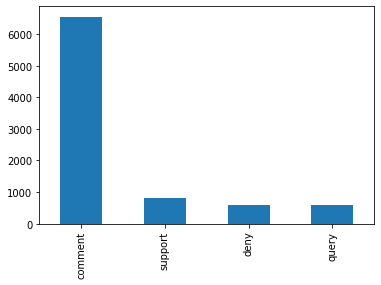

In [ ]:
dataset['Class'].value_counts().plot(kind = 'bar')

In [ ]:
dataset['Class'].value_counts()

comment    6548
support     812
deny        584
query       582
Name: Class, dtype: int64

## Exploration Conclusion

Both datasets are hugely imbalanced as most tweets are dominated by comment type class.

The docuentation at https://nlp.stanford.edu/projects/glove/ provides a Ruby Script for preprocessing twitter data:

https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

I will attempt to recreate these functions in python to match the GloVe embedding as closesly as possible. From my interpretation of ruby this includes:

- replacing urls with: < URL>
- splitting words around '/'
- replacing @tags with < USER>
- replacing smiley faces e.g. :) ;) with < SIMLE>
- replacing :P with < LOLFACE>
- replacing sad faces with < SADFACE>
- replacing :/ with < NEUTRALFACE>
- replacing <3 with < HEART>
- replacing digits with < NUMBER>
- replacing # with < HASHTAG>
- Marking repeat punctuation (eg. "!!!" => "! < REPEAT>")
- Marking elongated words (eg. "wayyyy" => "way < ELONG>")


The script works in in sequential order so :/ will not replace https:// with https< NEUTRALFACE>/




# Cleaning Data for GloVe


The dataset was converted to lowercase,  non-alpha numeric characters, duplicates and stopwords removed as is practice for NLP models. Following from this a base vocabulary on this dataset was generated and transferred to the twitter 27b 50d GloVe embedding. 


## Cleaning Functions


Originally the text cleaning was carried out according to the ruby script for twitter embeddings https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
However this was degrading my performance so i reverted to a simple processing scheme which is present in report

In [ ]:
cleaningFunctions = []

### URL

def txt_process_URL(text):
    process = re.compile(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*') 
    return process.sub("  ", text)
#<URL>
cleaningFunctions.append(txt_process_URL)
### @TAG 
def txt_process_TAG(text):
  process = re.compile(r"@\w+")
  return process.sub(" ", text)
#<USER>
cleaningFunctions.append(txt_process_TAG)
## Apostrophe
def txt_process_Apostrophe(text):
  process = re.compile(r"\'")
  return process.sub("", text)
#<USER>
cleaningFunctions.append(txt_process_Apostrophe)
### Faces
#### Smiley
def txt_process_SMILE(text):
  process = re.compile(r'(\s?:X|:|;|=|8)(?:-)?(?:\)+|O|D|S|\\|\/\s){1,}')
  return process.sub("  ", text)

# cleaningFunctions.append(txt_process_SMILE)
#### Sad
def txt_process_SADFACE(text):
  process = re.compile(r'(\s?:X|:|;|=|8)(?:-)?(?:\(|\\|\s{1,})')
  return process.sub(" <SADFACE> ", text)

# cleaningFunctions.append(txt_process_SADFACE)
#### LOL

def txt_process_LOLFACE(text):
  process = re.compile(r'(\s?:X|:|;|=|8)(?:-)?(?:\/|l*\s{1,})')
  return process.sub(" <LOLFACE> ", text)

# cleaningFunctions.append(txt_process_LOLFACE)
#### Neutral
def txt_process_NEUTRALFACE(text):
  process = re.compile(r'(\s?:X|:|;|=|8)(?:-)?(?:\/{1,})')
  return process.sub(" <NEUTRALFACE> ", text)

# cleaningFunctions.append(txt_process_NEUTRALFACE)
### Heart
def txt_process_HEART(text):
  process = re.compile(r'<3')
  return process.sub(" <HEART> ", text)

# cleaningFunctions.append(txt_process_HEART)
### Number
def txt_process_NUMBER(text):
  process = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
  return process.sub(" ", text)
  
cleaningFunctions.append(txt_process_NUMBER)
### Hashtag
def txt_process_HASHTAG(text):
  process = re.compile(r'[#]+')
  return process.sub(" <HASHTAG> ", text)

# cleaningFunctions.append(txt_process_HASHTAG)
### Symbol Repeat
#remove symbols
def txt_process_Symbols(text):
  process = re.compile(r'[^\w+]')
  return process.sub(" ", text)

cleaningFunctions.append(txt_process_Symbols)
# def txt_process_RPT_SYMBOL(text):
#   process = re.compile(r'([!?.]){2,}')
#   return process.sub(r"\1 <REPEAT> ", text)

# txt_process_RPT_SYMBOL("NICE!!!!!!!")


# cleaningFunctions.append(txt_process_RPT_SYMBOL)
txt_process_Symbols("tseteing. asdf?")
### Elongated Words
def txt_process_ELONGATED_WORD(text):
  process = re.compile(r'\b(\S*?)(.)\2{2,}\b')
  return process.sub(r"\1\2 <ELONG> ", text)

txt_process_ELONGATED_WORD("NICEEEEE!")

# cleaningFunctions.append(txt_process_ELONGATED_WORD)
### AllCaps
def low_case_replacement(match):
  return match.group(1).lower() 


def findAllCaps(text):
  process = re.compile(r'([^a-z0-9()<>\'`\-])')
  return process.sub(low_case_replacement , text)
 
def txt_process_ALLCAPS(text):
  txt = findAllCaps(text)
  return txt  + " <ALLCAPS > "



# cleaningFunctions.append(txt_process_ALLCAPS)

def remove_nonAlpha(text):
  process = re.compile(r'[^a-zA-Z\s]')
  return process.sub("", text)

cleaningFunctions.append(remove_nonAlpha)





## Master Cleaning Function

In [ ]:

def masterCleaning(series) :
  for i in cleaningFunctions:
    series = series.apply(lambda x: i(x))

  return series


# Evaluation Functions

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(predictions_, true, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):


    classes1 = list(decode.keys())
    for index, key in enumerate(classes1):
      classes1[index] = str(key) + " : " + str(decode[key])

    classes2 = list(decode.keys())

    for index, key in enumerate(classes2):
      classes1[index] = str(key) + " : " + str(decode[key])

    cm1 = confusion_matrix(predictions_, true)

    cm2 = confusion_matrix(predictions_, true)
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(cm1, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes1))
    plt.xticks(tick_marks, classes1, rotation=90)
    plt.yticks(tick_marks, classes1)

    if normalize:
        cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

  

    thresh = cm1.max() / 2.
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        plt.text(j, i, cm1[i, j],
            horizontalalignment="center",
            color="white" if cm1[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



## Running Cleaning Functions

In [ ]:
clean_data = dataset
clean_data['Text'] = masterCleaning(clean_data['Text'])
clean_data['Source_text'] = masterCleaning(clean_data['Source_text'])
clean_data

Type  ...                                        Source_text
1     Reply  ...    U  Robin names Andreas Lubitz as the copilot...
2     Reply  ...    U  Robin names Andreas Lubitz as the copilot...
4     Reply  ...  RT    German media reporting  AndreasLubitz ha...
5     Reply  ...  RT    German media reporting  AndreasLubitz ha...
6     Reply  ...  RT    German media reporting  AndreasLubitz ha...
...     ...  ...                                                ...
2466  Reply  ...  Iodine increases IQ and is an essential part o...
2467  Reply  ...  Iodine increases IQ and is an essential part o...
2468  Reply  ...  Iodine increases IQ and is an essential part o...
2469  Reply  ...  Iodine increases IQ and is an essential part o...
2470  Reply  ...  Iodine increases IQ and is an essential part o...

[8526 rows x 7 columns]

## Plotter function

In [ ]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0], *args, Name= None):
  plt.figure(figsize=(10,10))
  
  if Name is not None:
    keys_to_extract = [Name]
    a_subset = {key: history_hold[key] for key in keys_to_extract}
    history_hold = a_subset

  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)


# Encoding Data


In [ ]:
encode = {
    "comment" : 0,
    "deny"  : 1,       
    "query" : 2,    
    "support" : 3   
}

import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopWords2 = []
stopWords = set(stopwords.words('english'))
for word in stopWords:
  if word != 'no' or word != "not":
    stopWords2.append(word)



clean_data["Class_num"] = clean_data["Class"].apply(lambda x: encode[x])
clean_data['Text'] = clean_data['Text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopWords2))
clean_data['Source_text'] = clean_data['Source_text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopWords2))

clean_data['Text'] = clean_data['Text'].apply(lambda words: " ".join(word.lower() for word in words.split() if len(word) >1))
clean_data['Source_text'] = clean_data['Source_text'].apply(lambda words: " ".join(word.lower() for word in words.split() if len(word) >1))

# clean_data[clean_data['Text'] == ' '].replace(' ', np.nan, inplace=True)
clean_data = clean_data[clean_data['Source_text'] != ""]
clean_data = clean_data[clean_data['Text'] != ""]


clean_data['Combined_text'] = "src " + clean_data['Source_text']  + " rply " + clean_data['Text'] 
clean_data.drop_duplicates(subset = ['Combined_text'], inplace = True)

# clean_data = clean_data[clean_data['Combined_text'] != ""]
clean_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Type  ...                                      Combined_text
1     Reply  ...  src robin names andreas lubitz copilot flight ...
4     Reply  ...  src rt german media reporting andreaslubitz se...
5     Reply  ...  src rt german media reporting andreaslubitz se...
6     Reply  ...  src rt german media reporting andreaslubitz se...
7     Reply  ...  src rt german media reporting andreaslubitz se...
...     ...  ...                                                ...
2452  Reply  ...  src iodine increases iq essential part human d...
2457  Reply  ...  src iodine increases iq essential part human d...
2459  Reply  ...  src iodine increases iq essential part human d...
2463  Reply  ...  src iodine increases iq essential part human d...
2467  Reply  ...  src iodine increases iq essential part human d...

[6902 rows x 9 columns]

In [ ]:
clean_data[clean_data.duplicated('Text')]

Type  ...                                      Combined_text
247   Reply  ...  src german news co pilot germanwings airbus wa...
406   Reply  ...  src omg prince rumoured performing toronto tod...
609   Reply  ...   src what think hillary suffering rply parkinsons
862   Reply  ...  src anyone knows marina joyce personally knows...
930   Reply  ...  src anyone knows marina joyce personally knows...
...     ...  ...                                                ...
1589  Reply  ...  src is true earth flat is proof why theres peo...
1600  Reply  ...  src is true earth flat is proof why theres peo...
1888  Reply  ...  src face facts immigrants commit fewer crimes ...
1959  Reply  ...  src face facts immigrants commit fewer crimes ...
2361  Reply  ...  src iodine increases iq essential part human d...

[141 rows x 9 columns]

In [ ]:
clean_data.isnull().values.sum()

0

# Tokenizing, Encoding, Splitting



## Tokenizing

### Tokenizing Function

In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopWords2 = []
stopWords = set(stopwords.words('english'))
for word in stopWords:
  if word != 'no' or word != "not":
    stopWords2.append(word)
    
def cleanse_tokenize(dataFrame):

    all_text_list = dataFrame['Combined_text'].values.tolist()

    source_text_list = dataFrame['Source_text'].values.tolist()

    reply_text_list = dataFrame['Text'].values.tolist()

    def tokenProcess(lines_):
      print("token")

      lines_return = list()

      for index,line in enumerate(lines_):
 
          tokens = word_tokenize(line)


          lines_return.append(tokens)
          if len(tokens) < 2:
            print(index, tokens)
      
      return lines_return


    return tokenProcess(all_text_list), tokenProcess(source_text_list), tokenProcess(reply_text_list)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text_lines_combined, text_lines_source, text_lines_reply = cleanse_tokenize(clean_data)

token
token
token
54 ['hear']
67 ['unusual']
70 ['implications']
88 ['omg']
95 ['know']
117 ['true']
147 ['signaled']
154 ['yessss']
167 ['assholes']
205 ['happened']
208 ['terrible']
212 ['noooo']
214 ['know']
234 ['surprise']
279 ['sigh']
319 ['told']
323 ['rip']
333 ['heavy']
334 ['heart']
341 ['oh']
344 ['moneyyyyy']
366 ['cares']
367 ['hey']
381 ['lol']
382 ['gt']
383 ['good']
385 ['loooooooooooooooooool']
386 ['concert']
392 ['probably']
405 ['noooooo']
413 ['wtf']
416 ['hope']
443 ['never']
445 ['yeah']
455 ['reset']
481 ['minivan']
500 ['parkinsons']
508 ['right']
512 ['putin']
513 ['all']
515 ['distemper']
517 ['evil']
520 ['none']
522 ['epilepsy']
527 ['parkinsons']
624 ['shoelesshillary']
641 ['unfit']
651 ['hahahahaha']
723 ['liar']
733 ['rapist']
734 ['bye']
747 ['smh']
760 ['delete']
762 ['oh']
764 ['deactivate']
775 ['really']
778 ['leave']
789 ['still']
791 ['get']
801 ['shut']
820 ['damn']
831 ['harass']
835 ['whaaaat']
844 ['kys']
857 ['stop']
885 ['hideawayhillary']


## Generating Vocabulary

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

def gen_padding(lines_Source, max_length = 55):


  tokenizer_obj_source = Tokenizer()
  tokenizer_obj_source.fit_on_texts(lines_Source)
  sequences_source = tokenizer_obj_source.texts_to_sequences(lines_Source)

  #Generates an index for every single word within corpus
  word_index = tokenizer_obj_source.word_index
  print("unique tokens - "+str(len(word_index)))
  vocab_size = len(tokenizer_obj_source.word_index) + 1
  print('vocab_size - '+str(vocab_size))

  # print(sequences_source)

  return pad_sequences(sequences_source, maxlen=max_length, padding='pre'), word_index, max_length




In [ ]:

def translateToSequence(test):
  # print(test)
  # print(type(word_index))
  endlst = []
  for lst in test:
    lstval = [word_index[key] for key in lst]
    endlst.append(lstval)
  return endlst

 

In [ ]:

# The combined word index is used for embedding and max_length
lines_pad_combo, word_index, max_length = gen_padding(text_lines_combined)

lines_pad_source = pad_sequences(translateToSequence(text_lines_source), maxlen=max_length, padding='pre')
lines_pad_reply = pad_sequences(translateToSequence(text_lines_reply), maxlen=max_length, padding='pre')

category =  clean_data['Class_num'].values


validation_split = 0.22

#Determine Shuffle index
indices = np.arange(lines_pad_combo.shape[0])
np.random.shuffle(indices)

# Shuffle index of datarames
lines_pad_combo = lines_pad_combo[indices]
lines_pad_source = lines_pad_source[indices]
lines_pad_reply = lines_pad_reply[indices]

# Shuffle index of labels
category = category[indices]

n_values = np.max(category) + 1
Y = np.eye(n_values)[category]

print(len(Y))
print(len(lines_pad_combo))
num_test_samples = int(validation_split * lines_pad_combo.shape[0])

# Sample from shuffled
x_train = lines_pad_combo[:-num_test_samples]
y_train = Y[:-num_test_samples]

print(len(x_train))
print(len(y_train))
y_test_TEMP = Y[-num_test_samples:]
x_val_pad_TEMP = lines_pad_combo[-num_test_samples:]


x_train_source = lines_pad_source[:-num_test_samples]
x_val_pad_TEMP_source = lines_pad_source[-num_test_samples:]

x_train_reply = lines_pad_reply[:-num_test_samples]
x_val_pad_TEMP_reply = lines_pad_reply[-num_test_samples:]

test_split = 0.5

print(len(x_val_pad_TEMP))
num_validation_samples = int(test_split * x_val_pad_TEMP.shape[0])
print(num_validation_samples)

x_val = x_val_pad_TEMP[:-num_validation_samples]
y_val = y_test_TEMP[:-num_validation_samples]

x_test = x_val_pad_TEMP[-num_validation_samples:]
y_test = y_test_TEMP[-num_validation_samples:]

print("y test", len(y_test))
print("x test", len(x_test))
print("x val", len(x_val))
print("y_val", len(y_val))

x_val_source = x_val_pad_TEMP_source[:-num_validation_samples]
x_test_source = x_val_pad_TEMP_source[-num_validation_samples:]


x_val_reply = x_val_pad_TEMP_reply[:-num_validation_samples]
x_test_reply = x_val_pad_TEMP_reply[-num_validation_samples:]




unique tokens - 11452
vocab_size - 11453
6902
6902
5384
5384
1518
759
y test 759
x test 759
x val 759
y_val 759


In [ ]:
word_index

{'src': 1,
 'rply': 2,
 'police': 3,
 'ferguson': 4,
 'the': 5,
 'sydney': 6,
 'people': 7,
 'paris': 8,
 'hostage': 9,
 'breaking': 10,
 'charliehebdo': 11,
 'killed': 12,
 'shot': 13,
 'get': 14,
 'one': 15,
 'hostages': 16,
 'robbery': 17,
 'says': 18,
 'amp': 19,
 'ottawa': 20,
 'would': 21,
 'sydneysiege': 22,
 'shooting': 23,
 'like': 24,
 'hillary': 25,
 'parliament': 26,
 'news': 27,
 'dead': 28,
 'attack': 29,
 'mike': 30,
 'cafe': 31,
 'still': 32,
 'video': 33,
 'reports': 34,
 'soldier': 35,
 'via': 36,
 'dont': 37,
 'war': 38,
 'true': 39,
 'say': 40,
 'suspect': 41,
 'this': 42,
 'french': 43,
 'immigrants': 44,
 'hill': 45,
 'know': 46,
 'memorial': 47,
 'if': 48,
 'gunman': 49,
 'us': 50,
 'knows': 51,
 'brexit': 52,
 'it': 53,
 'brown': 54,
 'time': 55,
 'germanwings': 56,
 'help': 57,
 'said': 58,
 'day': 59,
 'isis': 60,
 'go': 61,
 'store': 62,
 'national': 63,
 'suspects': 64,
 'channel': 65,
 'think': 66,
 'god': 67,
 'least': 68,
 'man': 69,
 'held': 70,
 'im': 7

## Translation Functions

### Translation Dict

In [ ]:

word_index_reverse = {}

for word, index in word_index.items():
  # print(index)
  # print(index, word)
  word_index_reverse[index] = word

word_index_reverse[2117]

'nephew'

In [ ]:
decode = {
    0  : "comment" ,
     1 :"deny"  ,       
    2: "query" ,    
     3 :"support"    
}

def decodeY(Y):
  labs = []
  for i in Y:
    # print(i)
    for j, val in enumerate(i):
      if val == 1:
        labs.append(decode[j])
  return labs
      

y_test_labs = decodeY(y_test)
y_val_labs = decodeY(y_val)

# TensorBoard

In [ ]:
# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

# Model Setup


In [ ]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_custom_f1', patience=30, mode = "max", restore_best_weights=True)
  ]

# tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1)

## EPOCHS

In [ ]:
EPOCH = 120

## Load Model Dependencies





In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Input, Lambda
from tensorflow.keras.models import Sequential, load_model



## Load Metric Dependencies

In [ ]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


## Custom F-1

In [ ]:
# from https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras/notebook

from tensorflow.keras import backend as K
import tensorflow as tf


def custom_f1(y_true, y_pred):    
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())

    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# Transfer Learning

In [ ]:
!cp /content/drive/'My Drive'/COSC2779/Assignment2/glove.twitter.27B.50d.txt .
file = open('glove.twitter.27B.50d.txt', encoding='utf-8')

embedding_dim = 50

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

Map vocab to GloVe vocabulary.

In [ ]:
def map_to_Glove(vocab_index, *args, Embed_ = None):
  if Embed_ is None:
    E_T = np.zeros((len(vocab_index) + 1, embedding_dim))
  np.zeros((len(vocab_index) + 1, embedding_dim))
  for word, i in vocab_index.items():
      embedding_vector = glove_vectors.get(word)
      if embedding_vector is not None:
          E_T[i] = embedding_vector
      if embedding_vector is  None:
          print(word)
  return E_T

E_T = map_to_Glove(word_index)

charliehebdo
sydneysiege
brexit
germanwings
mikebrown
michaelbrown
savemarinajoyce
ourannualyear
charb
hurricaneharvy
ottawashooting
cbcnews
zehaf
ottawas
hillaryshealth
gunmans
jesuischarlie
bibeau
bossfeed
martinplace
iodized
sopel
kouachi
kouachibrothers
geoblock
parisattacks
tignous
capestorm
weatherforecast
gunmens
wolinski
martinplacesiege
sydneyseige
bebeau
henrydavis
dammartin
standforcanada
neurotoxin
merabet
otnorot
putindead
ripnathancirillo
jesuisjuif
goele
andreaslubitz
dgac
ofcr
sheffingdell
martinpl
charliehebdos
nxivm
hoppla
argylls
dramaalert
unformed
hillarys
wildfi
isisattacks
sagans
lubitz
netralized
lookingfornarnia
ramzankadyrov
kabayeva
sickhillary
ottawastrong
unarmedblacks
stopkillinginnocentpeople
freeburma
riflemen
germanwingscrash
barcelonette
crookedhillary
islamics
illridewithyou
parisattack
qaedas
asquat
houstonflood
grossmans
rbutr
notallimmigrants
sonderheimer
vidalies
neverhillary
whereshillary
radicalised
harperadminstration
zahaf
justiceformikebrown


In [ ]:
# !pip install tensorflow-addons
# import tensorflow_addons as tfa

#Model 1 - Baseline Trainable Embedding

In [ ]:
modelResults = {}
finalModels = {}

## Compiling Model

In [ ]:

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=max_length,
                            trainable=True)

model_1 = Sequential()
model_1.add(embedding_layer)
model_1.add(LSTM(units=32,  dropout=0.4, recurrent_dropout=0.25))

model_1.add(Dense(4, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[custom_f1,'categorical_accuracy'])

print(model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 50)            572650    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                10624     
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 583,406
Trainable params: 583,406
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [ ]:
m_histories = {}
modelCheckpoints = {}

In [ ]:
m_histories['no_TL'] = model_1.fit(x_train, y_train, batch_size=1024, epochs=EPOCH, validation_data=(x_val, y_val), verbose=1,)


Epoch 1/120
6/6 [==============================] - 4s 283ms/step - loss: 1.3703 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.5598 - val_loss: 1.3353 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.7510
Epoch 2/120
6/6 [==============================] - 1s 211ms/step - loss: 1.3074 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.7368 - val_loss: 1.2419 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.7523
Epoch 3/120
6/6 [==============================] - 1s 217ms/step - loss: 1.1797 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.7368 - val_loss: 1.0300 - val_custom_f1: 0.0102 - val_categorical_accuracy: 0.7523
Epoch 4/120
6/6 [==============================] - 1s 212ms/step - loss: 0.9564 - custom_f1: 0.1712 - categorical_accuracy: 0.7368 - val_loss: 0.8718 - val_custom_f1: 0.2147 - val_categorical_accuracy: 0.7523
Epoch 5/120
6/6 [==============================] - 1s 216ms/step - loss: 0.9065 - custom_f1: 0.2118 - categorical_accuracy: 0.7368 - val_loss: 0

In [ ]:
!mkdir -p saved_model
model_1.save("/saved_model/1")

INFO:tensorflow:Assets written to: /saved_model/1/assets


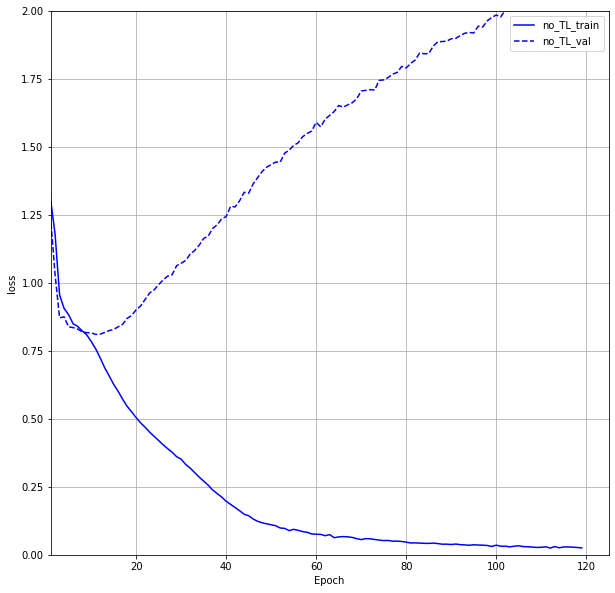

In [ ]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

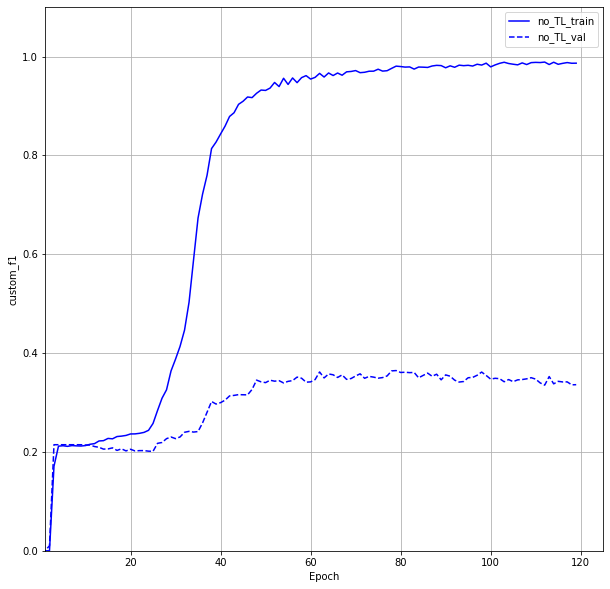

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:

predictions = model_1.predict(x_val)

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes



predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])



In [ ]:
report = metrics.classification_report(y_val_labs,predicted_labs, output_dict = True) 
modelResults['M1'] = report
print(metrics.classification_report(y_val_labs,predicted_labs))

              precision    recall  f1-score   support

     comment       0.79      0.78      0.79       571
        deny       0.26      0.26      0.26        61
       query       0.14      0.16      0.15        50
     support       0.17      0.16      0.16        77

    accuracy                           0.64       759
   macro avg       0.34      0.34      0.34       759
weighted avg       0.64      0.64      0.64       759



Confusion matrix, without normalization


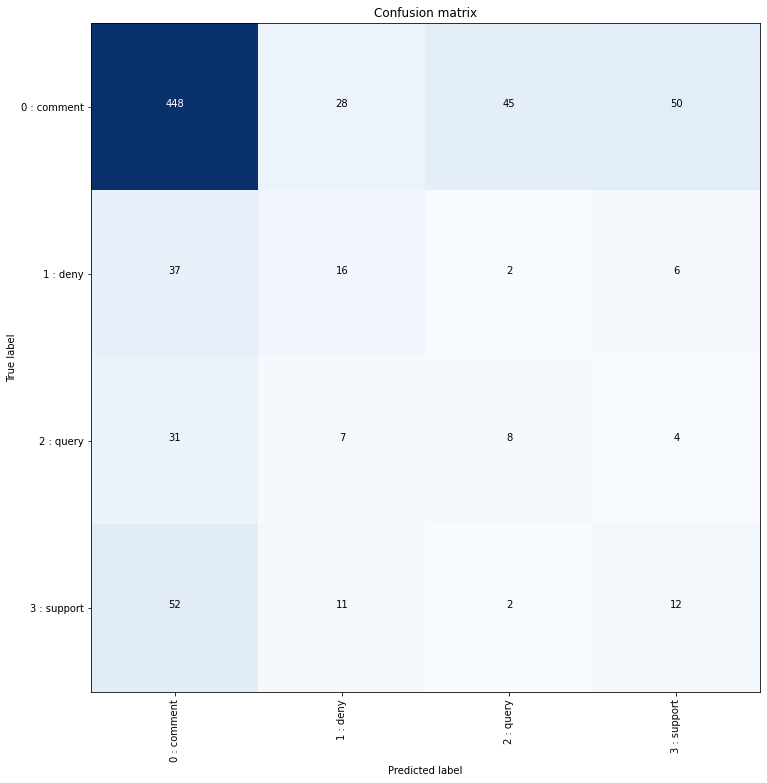

In [ ]:
plot_confusion_matrix(y_val_labs,predicted_labs)

# Model 2 w/ Glove Embedding



## Compiling Model

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Masking
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_2 = Sequential()
model_2.add(embedding_layer_TL)
model_2.add(LSTM(units=32,  dropout=0.4, recurrent_dropout=0.25))
model_2.add(Dense(4, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[custom_f1, 'categorical_accuracy'])

print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 55, 50)            572650    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 583,406
Trainable params: 10,756
Non-trainable params: 572,650
_________________________________________________________________
None


## Train

In [ ]:
m_histories['with_TL'] =  model_2.fit(x_train, y_train, batch_size=1024, epochs=EPOCH, validation_data=(x_val, y_val), callbacks=get_callbacks('models/no_TL'), verbose=1)

Epoch 1/120
6/6 [==============================] - 4s 299ms/step - loss: 1.3488 - custom_f1: 5.6144e-04 - categorical_accuracy: 0.3570 - val_loss: 1.1224 - val_custom_f1: 0.0159 - val_categorical_accuracy: 0.7115
Epoch 2/120
6/6 [==============================] - 1s 232ms/step - loss: 1.1165 - custom_f1: 0.0613 - categorical_accuracy: 0.6805 - val_loss: 0.9415 - val_custom_f1: 0.1884 - val_categorical_accuracy: 0.7470
Epoch 3/120
6/6 [==============================] - 1s 213ms/step - loss: 0.9742 - custom_f1: 0.1754 - categorical_accuracy: 0.7316 - val_loss: 0.8644 - val_custom_f1: 0.2123 - val_categorical_accuracy: 0.7510
Epoch 4/120
6/6 [==============================] - 1s 215ms/step - loss: 0.9061 - custom_f1: 0.2067 - categorical_accuracy: 0.7361 - val_loss: 0.8458 - val_custom_f1: 0.2140 - val_categorical_accuracy: 0.7523
Epoch 5/120
6/6 [==============================] - 1s 209ms/step - loss: 0.8816 - custom_f1: 0.2111 - categorical_accuracy: 0.7366 - val_loss: 0.8502 - val_cust

In [ ]:
model_2.save("/saved_model/2")

INFO:tensorflow:Assets written to: /saved_model/2/assets


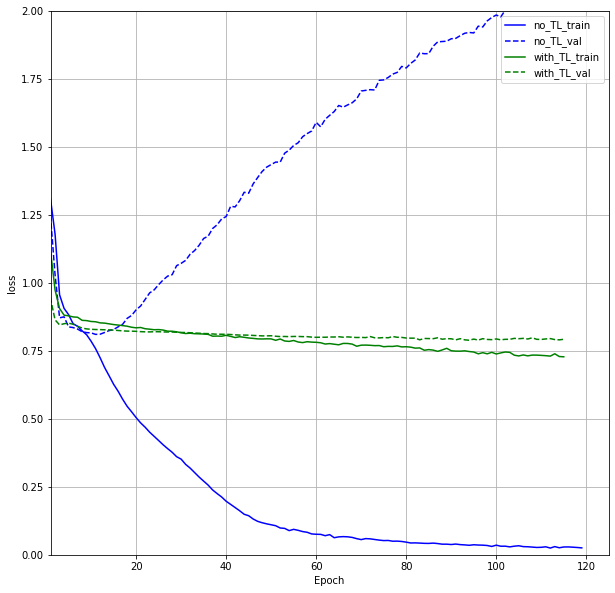

In [ ]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

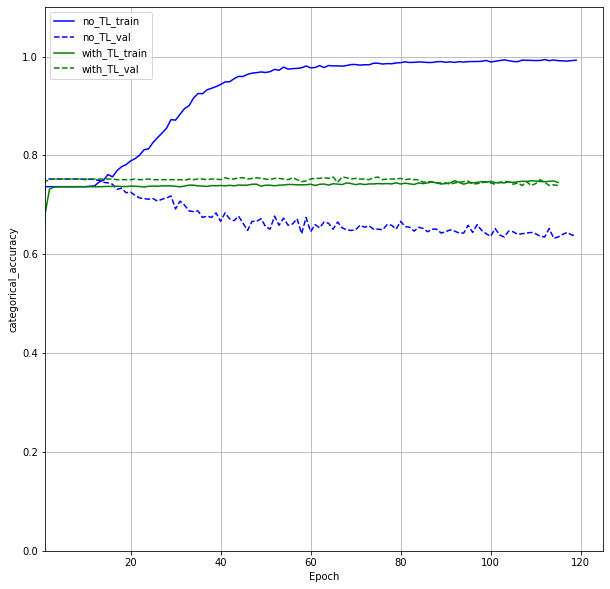

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

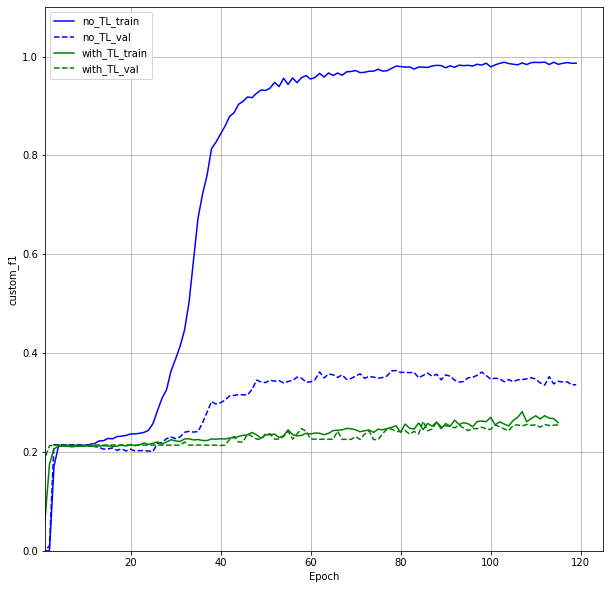

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:
predictions = model_2.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)

predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])


In [ ]:
report = metrics.classification_report(y_val_labs, predicted_labs, output_dict= True)
modelResults['M2'] = report

print(metrics.classification_report(y_val_labs,predicted_labs))

              precision    recall  f1-score   support

     comment       0.76      0.97      0.85       571
        deny       0.29      0.03      0.06        61
       query       0.00      0.00      0.00        50
     support       0.38      0.10      0.16        77

    accuracy                           0.75       759
   macro avg       0.36      0.28      0.27       759
weighted avg       0.63      0.75      0.66       759



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization


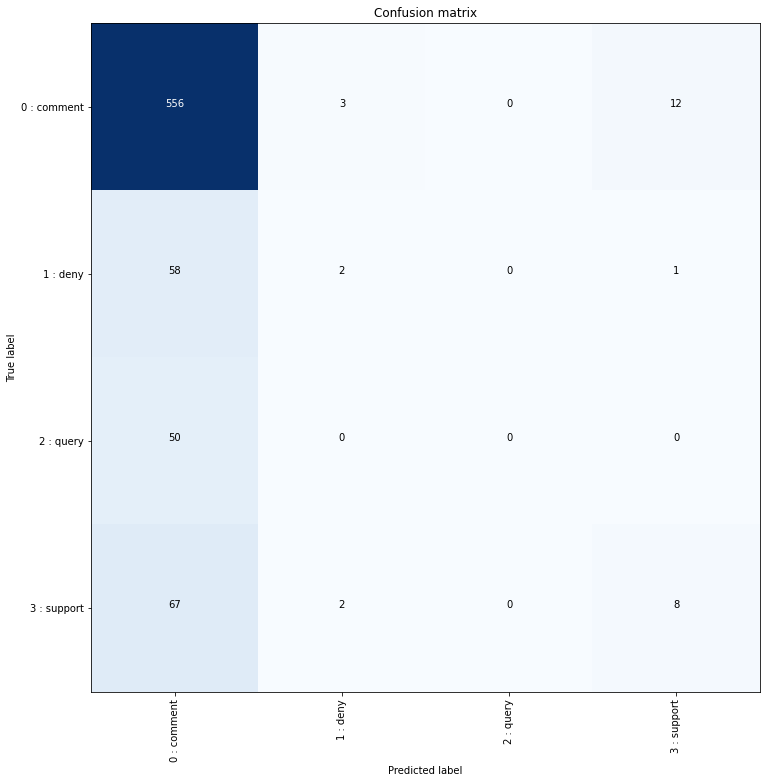

In [ ]:
plot_confusion_matrix(y_val_labs,predicted_labs)

# Model 3 w/ Glove w/ Class weighting

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(clean_data['Class_num']),
                                                 clean_data['Class_num'])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.33786959075778344,
 1: 3.219216417910448,
 2: 3.2434210526315788,
 3: 2.3734525447042643}

## Train

In [ ]:
embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_itr = Sequential()
model_itr.add(embedding_layer_TL)
model_itr.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))

model_itr.add(Dense(4, activation='softmax'))

model_itr.compile(loss='categorical_crossentropy', optimizer='adam', metrics= [custom_f1,'categorical_accuracy'])


## Compile

In [ ]:
m_histories['with_TL_ClassBalancing'] = model_itr.fit(x_train, y_train, batch_size=1024, epochs=EPOCH, validation_data=(x_val, y_val), callbacks=get_callbacks('models/no_TL'), verbose=1, class_weight= class_weights)

Epoch 1/120
6/6 [==============================] - 4s 267ms/step - loss: 1.4018 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.1986 - val_loss: 1.3643 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.3254
Epoch 2/120
6/6 [==============================] - 1s 198ms/step - loss: 1.3879 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.3336 - val_loss: 1.3732 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2793
Epoch 3/120
6/6 [==============================] - 1s 190ms/step - loss: 1.3769 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.2574 - val_loss: 1.4229 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.1858
Epoch 4/120
6/6 [==============================] - 1s 211ms/step - loss: 1.3679 - custom_f1: 0.0042 - categorical_accuracy: 0.2279 - val_loss: 1.3962 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2148
Epoch 5/120
6/6 [==============================] - 1s 206ms/step - loss: 1.3573 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.2888 -

In [ ]:
model_itr.save("/saved_model/3")

INFO:tensorflow:Assets written to: /saved_model/3/assets


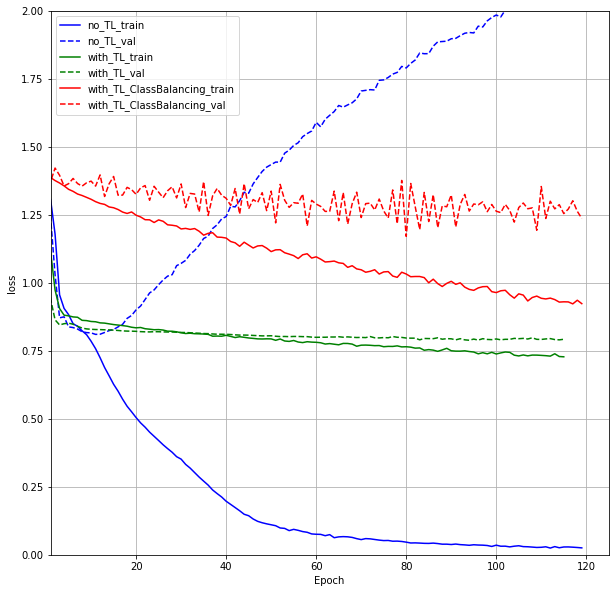

In [ ]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

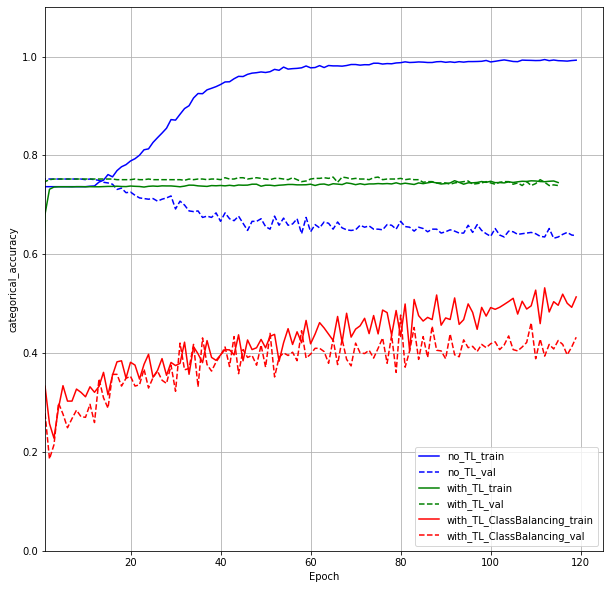

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

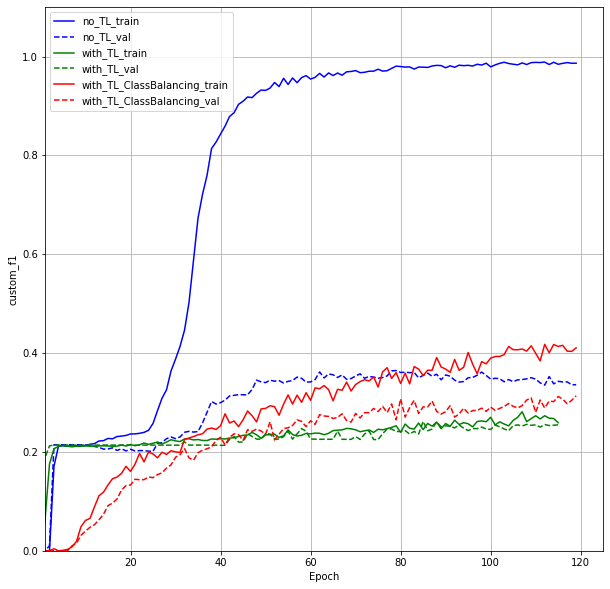

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:
predictions = model_itr.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)

predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])


In [ ]:
report = metrics.classification_report(y_val_labs,predicted_labs, output_dict = True)
modelResults['M3'] = report

print(metrics.classification_report(y_val_labs,predicted_labs))

              precision    recall  f1-score   support

     comment       0.87      0.42      0.57       571
        deny       0.19      0.57      0.29        61
       query       0.19      0.52      0.28        50
     support       0.16      0.34      0.22        77

    accuracy                           0.43       759
   macro avg       0.35      0.46      0.34       759
weighted avg       0.70      0.43      0.49       759



Confusion matrix, without normalization


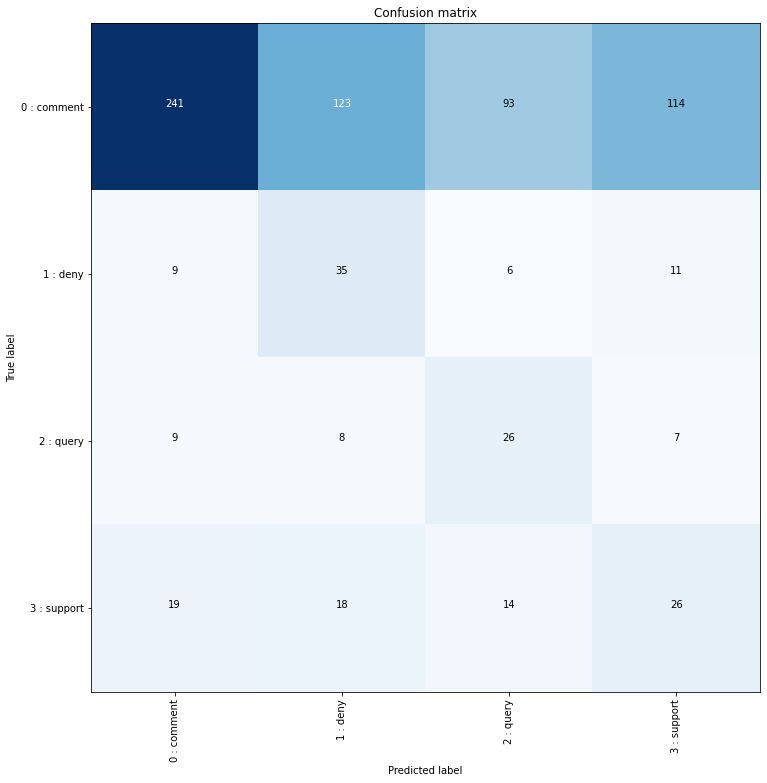

In [ ]:
plot_confusion_matrix(y_val_labs,predicted_labs)

# Model 4 GLove w/Trainable embedding & class weighting

## Compile

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(clean_data['Class_num']),
                                                 clean_data['Class_num'])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.33786959075778344,
 1: 3.219216417910448,
 2: 3.2434210526315788,
 3: 2.3734525447042643}

In [ ]:
embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=True)

model_itr = Sequential()
model_itr.add(embedding_layer_TL)
model_itr.add(LSTM(units=32,  dropout = 0.2, recurrent_dropout= 0.25, return_sequences= False))
# model_itr.add(Bidirectional(LSTM(units=64,  dropout = 0.4, recurrent_dropout= 0.25,)))

model_itr.add(Dense(4, activation='softmax'))

model_itr.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[custom_f1,'categorical_accuracy'])

## Train

In [ ]:
m_histories['with_TL_ClassBalancing_trainableembed'] = model_itr.fit(x_train, y_train, batch_size=1024, epochs=EPOCH, validation_data=(x_val, y_val), callbacks=get_callbacks('models/no_TL'), verbose=1, class_weight = class_weights)

Epoch 1/120
6/6 [==============================] - 4s 282ms/step - loss: 1.4356 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.3900 - val_loss: 1.3379 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.4097
Epoch 2/120
6/6 [==============================] - 1s 238ms/step - loss: 1.3973 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.3245 - val_loss: 1.4282 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2161
Epoch 3/120
6/6 [==============================] - 1s 215ms/step - loss: 1.3852 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.2049 - val_loss: 1.4403 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.1607
Epoch 4/120
6/6 [==============================] - 1s 232ms/step - loss: 1.3716 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.1908 - val_loss: 1.4267 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.1765
Epoch 5/120
6/6 [==============================] - 1s 237ms/step - loss: 1.3551 - custom_f1: 7.8616e-04 - categorical_accuracy: 0.23

In [ ]:
model_itr.save("/saved_model/4")

INFO:tensorflow:Assets written to: /saved_model/4/assets


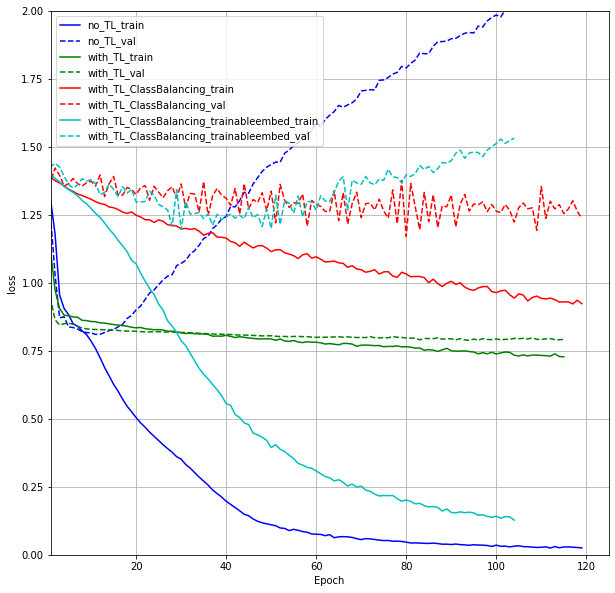

In [ ]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

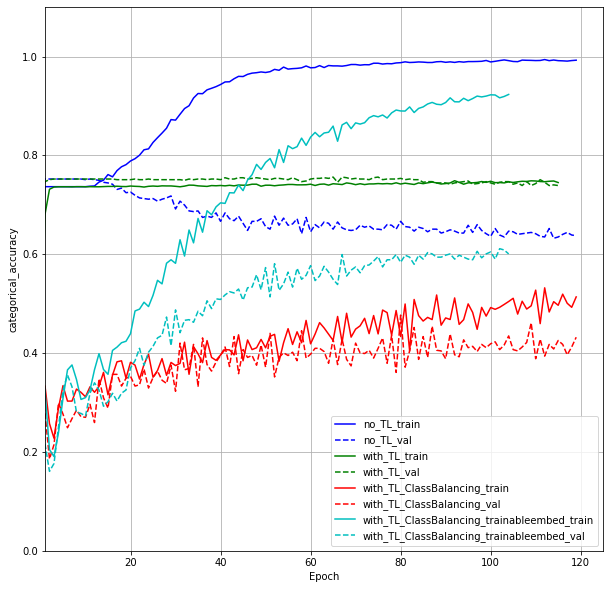

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

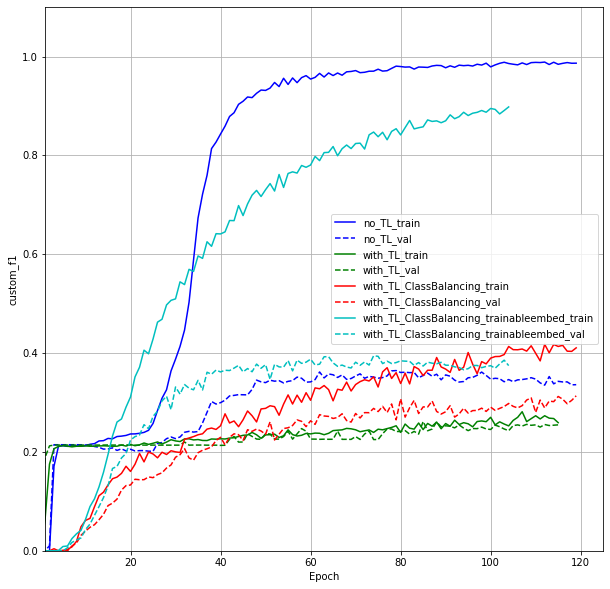

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:
predictions = model_itr.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)

predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])


In [ ]:
report = metrics.classification_report(y_val_labs,predicted_labs, output_dict = True)
modelResults['M4'] = report

print(metrics.classification_report(y_val_labs,predicted_labs))

              precision    recall  f1-score   support

     comment       0.82      0.66      0.73       571
        deny       0.31      0.41      0.35        61
       query       0.17      0.36      0.24        50
     support       0.21      0.31      0.25        77

    accuracy                           0.59       759
   macro avg       0.38      0.44      0.39       759
weighted avg       0.67      0.59      0.62       759



Confusion matrix, without normalization


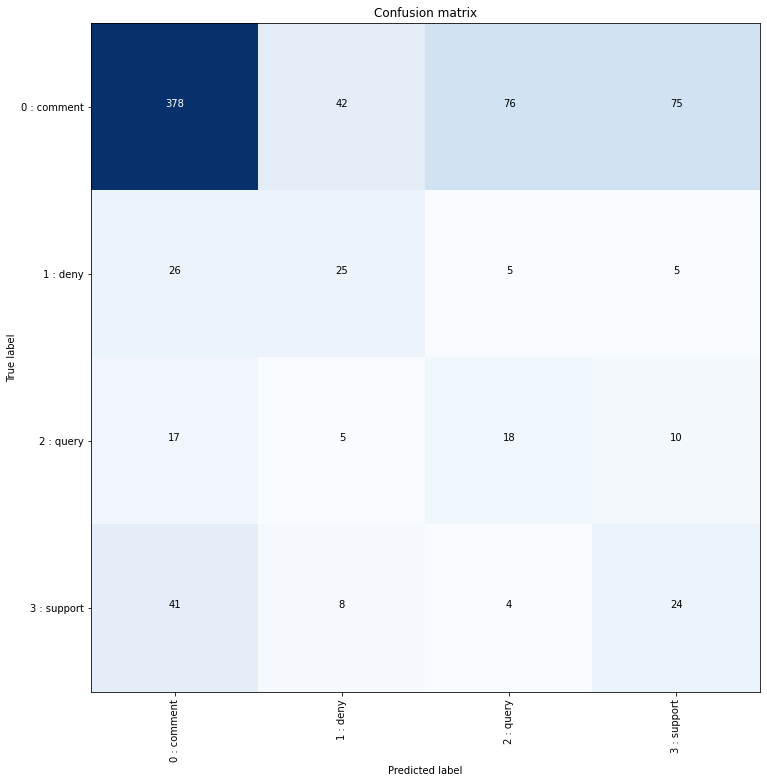

In [ ]:
plot_confusion_matrix(y_val_labs,predicted_labs)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(clean_data['Class_num']),
                                                 clean_data['Class_num'])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.33786959075778344,
 1: 3.219216417910448,
 2: 3.2434210526315788,
 3: 2.3734525447042643}

# Model 5 Multi Input source/reply - Baseline w/ class weighting

## Compile

In [ ]:
import tensorflow.keras as keras
import tensorflow

yinput = keras.Input(shape = max_length)
yinput2 = keras.Input(shape = max_length)


shared_embedding = keras.layers.Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

shared_embedding.embeddings_regularizer =  tensorflow.keras.regularizers.l2(1e-3)

encoded_input_a = shared_embedding(yinput)
encoded_input_b = shared_embedding(yinput2)

combined = keras.layers.concatenate([encoded_input_a, encoded_input_b])
y = keras.layers.Dropout(0.3)(combined)

y_1 = LSTM(units=64,  dropout = 0.5, recurrent_dropout= 0.25)(y)

# y = keras.layers.Dense(16)(combined)
y = keras.layers.Dense(4, activation='softmax')(y_1)

model_itr = keras.Model(
    inputs=[yinput,yinput2], outputs= y, name = "MobileNetBase"
)

model_itr.compile(
 loss='categorical_crossentropy', optimizer='adam', metrics=[custom_f1,'categorical_accuracy'])
model_itr.summary()

Model: "MobileNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 55, 50)       572650      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 55, 100)      0           embedding_4[0][0]    

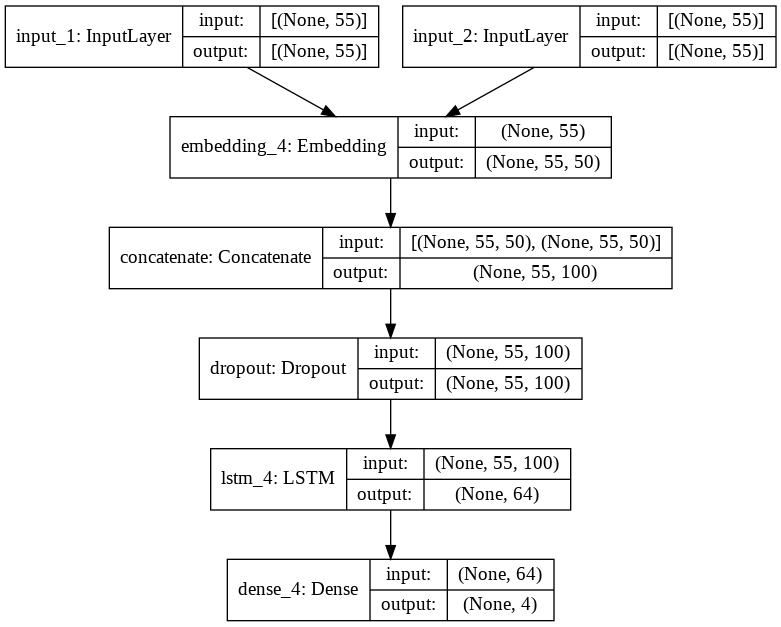

In [ ]:
keras.utils.plot_model(model_itr, "multi_input_and_output_model.png", show_shapes=True)


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(clean_data['Class_num']),
                                                 clean_data['Class_num'])
class_weights = dict(enumerate(class_weights))
# class_weights[0] = class_weights[0]  *1
class_weights

{0: 0.33786959075778344,
 1: 3.219216417910448,
 2: 3.2434210526315788,
 3: 2.3734525447042643}

## Train

In [ ]:
m_histories['Multi_in_1'] = model_itr.fit([x_train_source,x_train_reply] , y_train, batch_size=512, epochs=EPOCH,
                                                validation_data=([x_val_source, x_val_reply], y_val),
                                                callbacks=get_callbacks('models/Functional'), verbose=1,
                                                class_weight = class_weights)
model_itr.save("/saved_model/5")

Epoch 1/120
11/11 [==============================] - 5s 235ms/step - loss: 256.0011 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.2762 - val_loss: 256.0022 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2042
Epoch 2/120
11/11 [==============================] - 2s 194ms/step - loss: 255.9650 - custom_f1: 1.2252e-04 - categorical_accuracy: 0.2593 - val_loss: 255.9896 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2187
Epoch 3/120
11/11 [==============================] - 2s 187ms/step - loss: 255.9520 - custom_f1: 1.1868e-04 - categorical_accuracy: 0.3098 - val_loss: 255.9297 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.3281
Epoch 4/120
11/11 [==============================] - 2s 194ms/step - loss: 255.9307 - custom_f1: 0.0032 - categorical_accuracy: 0.3405 - val_loss: 255.9471 - val_custom_f1: 0.0301 - val_categorical_accuracy: 0.2806
Epoch 5/120
11/11 [==============================] - 2s 204ms/step - loss: 255.9173 - custom_f1: 0.0253 - categorica

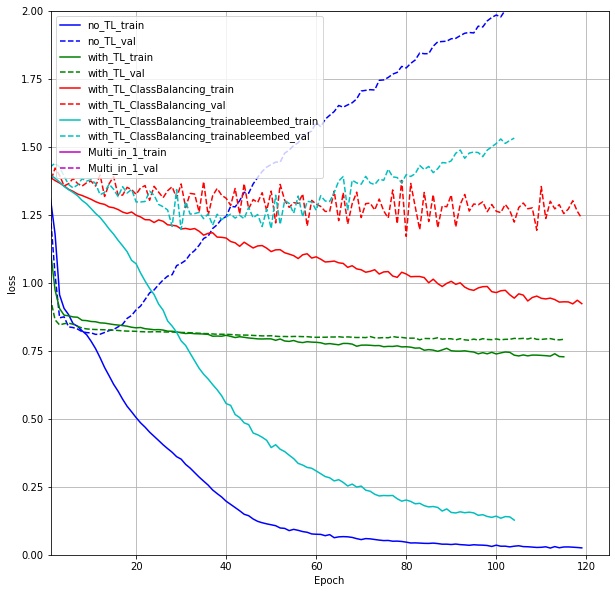

In [ ]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

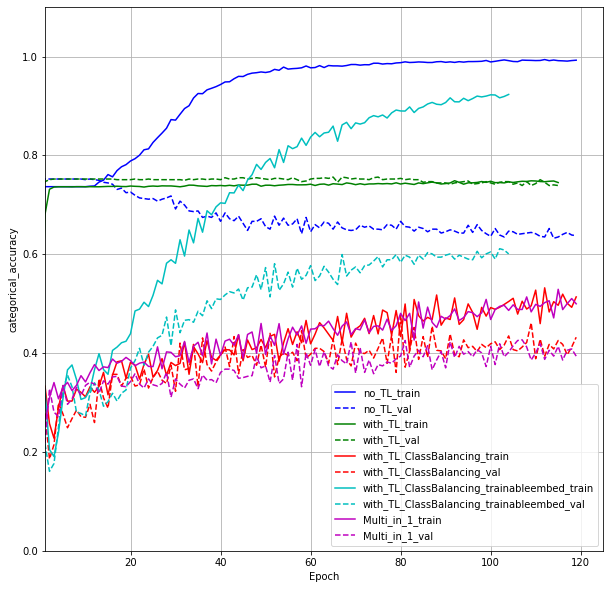

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

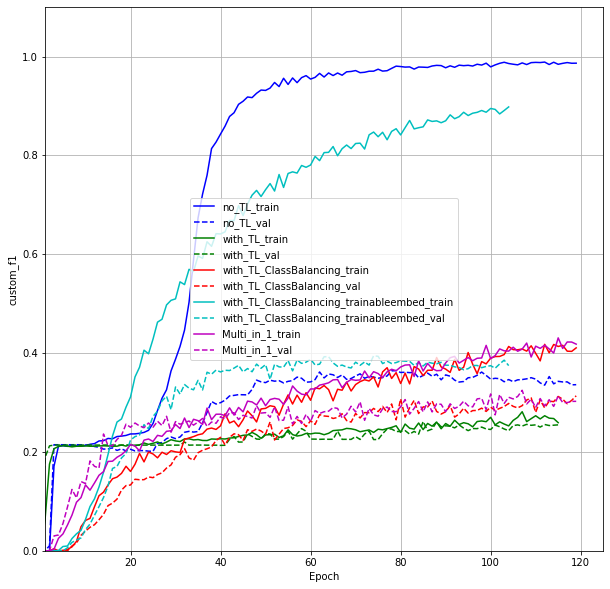

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:
predictions = model_itr.predict([x_val_source, x_val_reply])

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

decode = {
    0  : "comment" ,
     1 :"deny"  ,       
    2: "query" ,    
     3 :"support"    
}

predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])



In [ ]:

report = metrics.classification_report(y_val_labs,predicted_labs, output_dict = True)
modelResults['M5'] = report

print(metrics.classification_report(y_val_labs,predicted_labs))

              precision    recall  f1-score   support

     comment       0.90      0.37      0.52       571
        deny       0.18      0.46      0.26        61
       query       0.13      0.58      0.21        50
     support       0.22      0.40      0.28        77

    accuracy                           0.39       759
   macro avg       0.36      0.45      0.32       759
weighted avg       0.72      0.39      0.46       759



Confusion matrix, without normalization


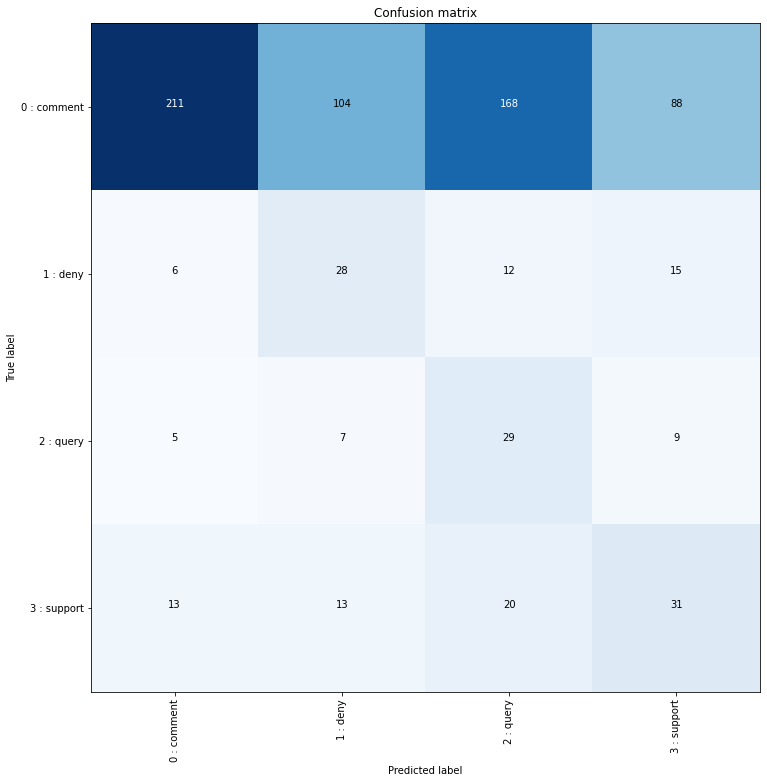

In [ ]:
plot_confusion_matrix(y_val_labs,predicted_labs)

# Model 6 Multi Input source/reply  with Shared Trainable Embedding


## Compile

In [ ]:
import tensorflow.keras as keras
import tensorflow

yinput = keras.Input(shape = max_length)
yinput2 = keras.Input(shape = max_length)


shared_embedding = keras.layers.Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=True)

shared_embedding.embeddings_regularizer =  tensorflow.keras.regularizers.l2(1e-3)

encoded_input_a = shared_embedding(yinput)
encoded_input_b = shared_embedding(yinput2)

combined = keras.layers.concatenate([encoded_input_a, encoded_input_b])
y = keras.layers.Dropout(0.3)(combined)

y_1 = LSTM(units=64,  dropout = 0.5, recurrent_dropout= 0.25)(y)

# y = keras.layers.Dense(16)(combined)
y = keras.layers.Dense(4, activation='softmax')(y_1)

model_itr = keras.Model(
    inputs=[yinput,yinput2], outputs= y, name = "MobileNetBase"
)

model_itr.compile(
 loss='categorical_crossentropy', optimizer='adam', metrics=[custom_f1,'categorical_accuracy'])
model_itr.summary()

Model: "MobileNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 55, 50)       572650      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 55, 100)      0           embedding_5[0][0]    

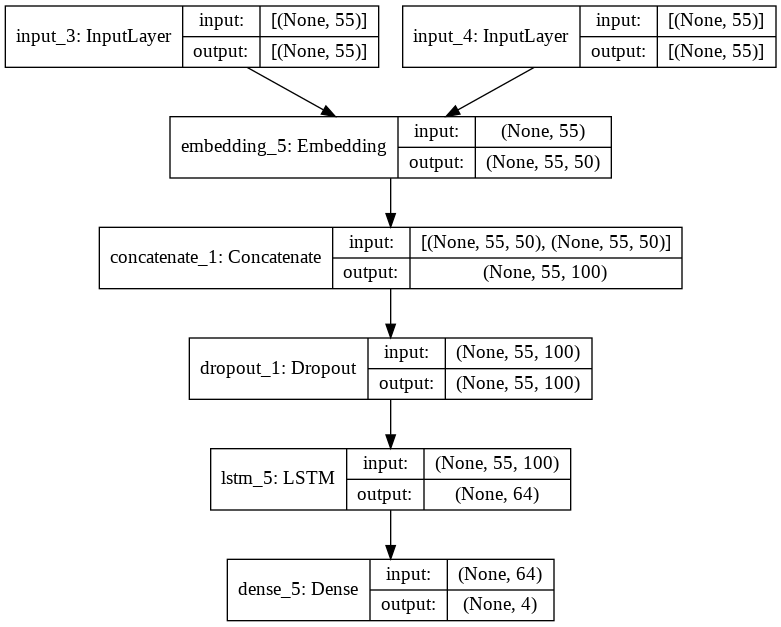

In [ ]:
keras.utils.plot_model(model_itr, "multi_input_and_output_model.png", show_shapes=True)


## Train

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(clean_data['Class_num']),
                                                 clean_data['Class_num'])
class_weights = dict(enumerate(class_weights))
# class_weights[0] = class_weights[0]  *1
class_weights

{0: 0.33786959075778344,
 1: 3.219216417910448,
 2: 3.2434210526315788,
 3: 2.3734525447042643}

In [ ]:
m_histories['Multi_in_2'] = model_itr.fit([x_train_source,x_train_reply] , y_train, batch_size=512, epochs=EPOCH,
                                                validation_data=([x_val_source, x_val_reply], y_val),
                                                callbacks=get_callbacks('models/Functional'), verbose=1,
                                                class_weight = class_weights)

Epoch 1/120
11/11 [==============================] - 5s 244ms/step - loss: 253.4310 - custom_f1: 0.0014 - categorical_accuracy: 0.2927 - val_loss: 250.0594 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2213
Epoch 2/120
11/11 [==============================] - 2s 212ms/step - loss: 247.5878 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.2208 - val_loss: 244.3849 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.1924
Epoch 3/120
11/11 [==============================] - 2s 225ms/step - loss: 241.8913 - custom_f1: 8.4175e-04 - categorical_accuracy: 0.2812 - val_loss: 238.6831 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.3715
Epoch 4/120
11/11 [==============================] - 2s 226ms/step - loss: 236.3486 - custom_f1: 0.0051 - categorical_accuracy: 0.3122 - val_loss: 233.2992 - val_custom_f1: 0.0243 - val_categorical_accuracy: 0.2859
Epoch 5/120
11/11 [==============================] - 2s 217ms/step - loss: 230.9839 - custom_f1: 0.0243 - categorical_ac

In [ ]:
model_itr.save("/saved_model/6")

INFO:tensorflow:Assets written to: /saved_model/6/assets


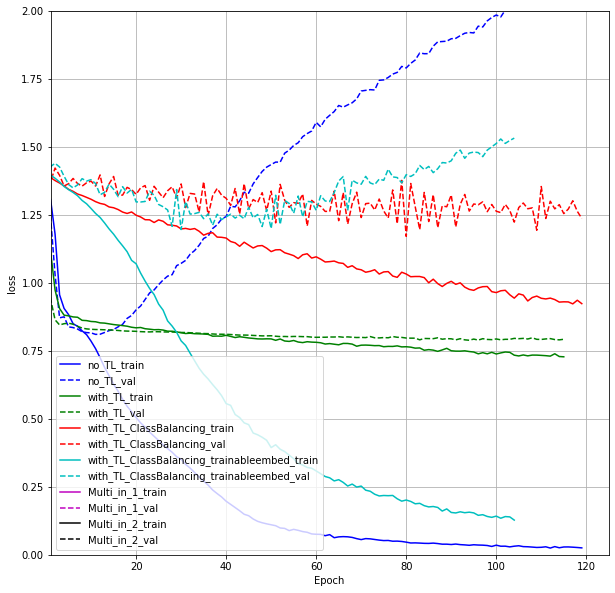

In [ ]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

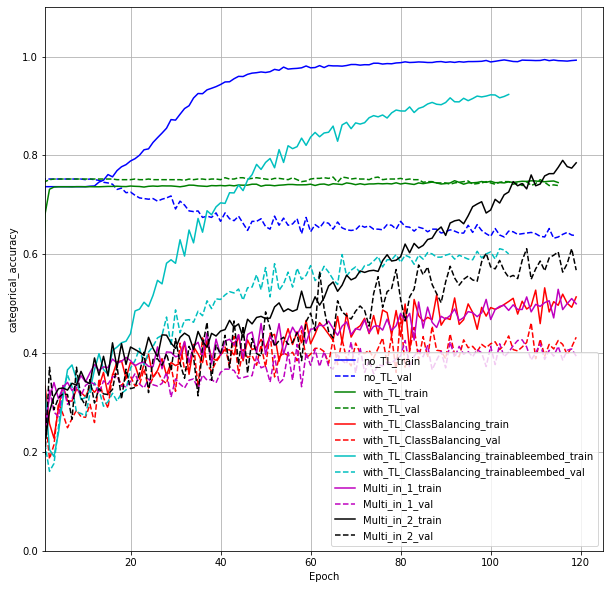

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

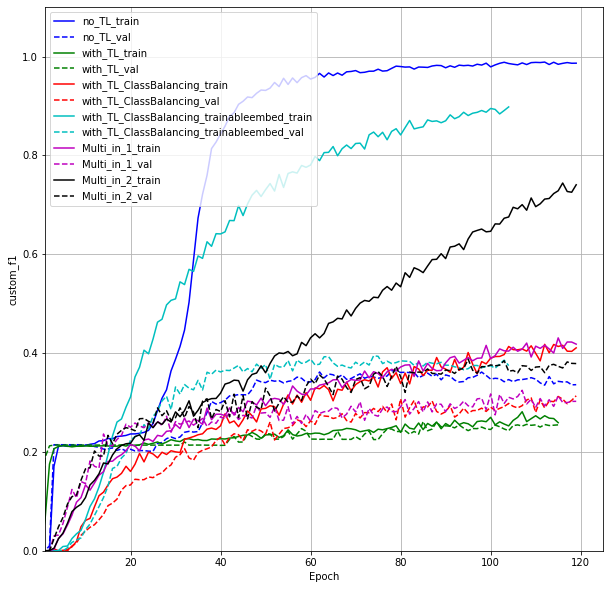

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:
# predictions = model_itr.predict([x_test_source, x_test_reply])
predictions = model_itr.predict([x_val_source, x_val_reply])

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

decode = {
    0  : "comment" ,
     1 :"deny"  ,       
    2: "query" ,    
     3 :"support"    
}

predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])



In [ ]:
from sklearn import metrics
report = metrics.classification_report(y_val_labs,predicted_labs, output_dict = True)
modelResults['M6'] = report

print(metrics.classification_report(y_val_labs,predicted_labs))

              precision    recall  f1-score   support

     comment       0.83      0.63      0.72       571
        deny       0.28      0.33      0.30        61
       query       0.22      0.42      0.29        50
     support       0.18      0.36      0.24        77

    accuracy                           0.57       759
   macro avg       0.38      0.44      0.39       759
weighted avg       0.68      0.57      0.61       759



Confusion matrix, without normalization


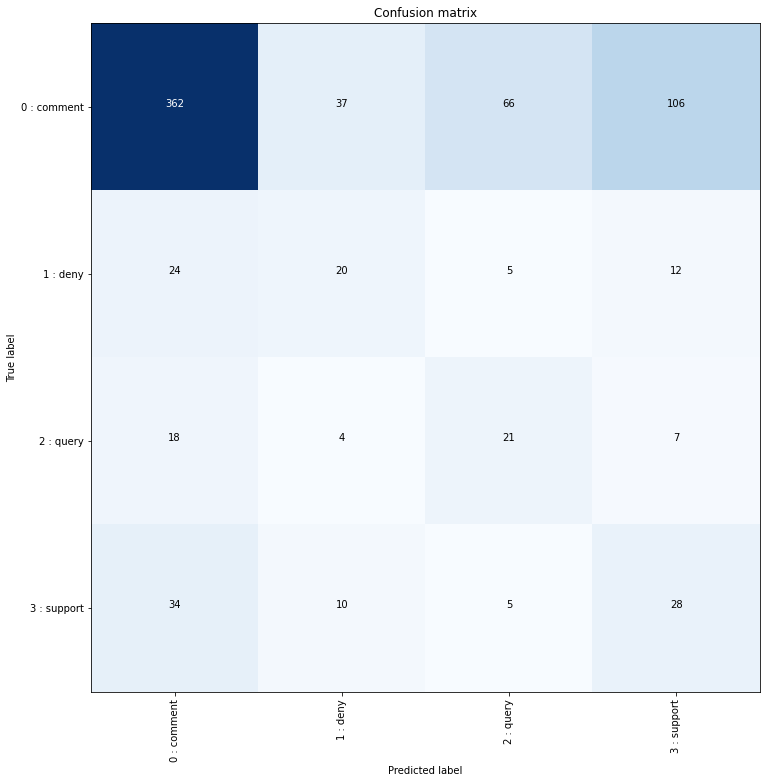

In [ ]:
plot_confusion_matrix(y_val_labs,predicted_labs)

# Model 7 - Pretraining on Sentiment Analysis - transfer

In [ ]:
!cp /content/drive/'My Drive'/COSC2779/Assignment2/'sentiment analsysis.zip' . 
!unzip -q -o 'sentiment analsysis.zip'


In [ ]:
sentiment = pd.read_csv('./Tweets.csv')
sentiment = sentiment[sentiment['airline_sentiment_confidence'] > 0.3]
sentiment

tweet_id  ...               user_timezone
0      570306133677760513  ...  Eastern Time (US & Canada)
1      570301130888122368  ...  Pacific Time (US & Canada)
2      570301083672813571  ...  Central Time (US & Canada)
3      570301031407624196  ...  Pacific Time (US & Canada)
4      570300817074462722  ...  Pacific Time (US & Canada)
...                   ...  ...                         ...
14635  569587686496825344  ...                         NaN
14636  569587371693355008  ...                         NaN
14637  569587242672398336  ...                         NaN
14638  569587188687634433  ...  Eastern Time (US & Canada)
14639  569587140490866689  ...                         NaN

[14640 rows x 15 columns]

In [ ]:
sentiment['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
positive_sen = sentiment[sentiment['airline_sentiment'] == "positive"]
negative_sen = sentiment[sentiment['airline_sentiment'] == "negative"]
neutral_sen = sentiment[sentiment['airline_sentiment'] == "neutral"]

In [ ]:
sentiment['text'] = masterCleaning(sentiment['text'])
sentiment

tweet_id  ...               user_timezone
0      570306133677760513  ...  Eastern Time (US & Canada)
1      570301130888122368  ...  Pacific Time (US & Canada)
2      570301083672813571  ...  Central Time (US & Canada)
3      570301031407624196  ...  Pacific Time (US & Canada)
4      570300817074462722  ...  Pacific Time (US & Canada)
...                   ...  ...                         ...
14635  569587686496825344  ...                         NaN
14636  569587371693355008  ...                         NaN
14637  569587242672398336  ...                         NaN
14638  569587188687634433  ...  Eastern Time (US & Canada)
14639  569587140490866689  ...                         NaN

[14640 rows x 15 columns]

In [ ]:
encodeSen = {"neutral" : 0, "negative" : 1, "positive" : 2}
deencodeSen = { 0 : "neutral", 1 : "negative" ,  2 : "positive"}

In [ ]:
sentiment['Class_num'] = sentiment['airline_sentiment'].apply(lambda x: encodeSen[x])

In [ ]:
def cleanse_tokenize_list(series):

    all_text_list = series.values.tolist()


    def tokenProcess(lines_):
      print("token")

      lines_return = list()

      for index,line in enumerate(lines_):
          # tokenize the text
          tokens = word_tokenize(line)

          # # convert to lower case
          tokens = [w.lower() for w in tokens]

          # # remove puntuations
          table = str.maketrans('', '', string.punctuation)
          stripped = [w.translate(table) for w in tokens]
          # stripped = [w.translate(tokens) for w in tokens]


          # remove non alphabetic characters
          # words = [word for word in stripped if word.isalpha()]
          words = [word for word in stripped] 

          lines_return.append(words)
          print(index, words)
      
      return lines_return


    return tokenProcess(all_text_list)

In [ ]:
sentiment['Class_num']

0        0
1        2
2        0
3        1
4        1
        ..
14635    2
14636    1
14637    0
14638    1
14639    0
Name: Class_num, Length: 14640, dtype: int64

In [ ]:
sen_x, sen_val = train_test_split(sentiment, test_size = 0.2)

sen_x_train = cleanse_tokenize_list(sen_x['text'])
sen_x_val = cleanse_tokenize_list(sen_val['text'])
sen_ALL = cleanse_tokenize_list(sentiment['text'])



sen_y_train = pd.get_dummies(sen_x['Class_num'])
sen_y_val = pd.get_dummies(sen_val['Class_num'])

sen_x_train, WL, ML=  gen_padding(sen_x_train)
sen_x_val, WL, ML =  gen_padding(sen_x_val)
sen_ALL, twitEmbed, ML =  gen_padding(sen_ALL)



Streaming output truncated to the last 5000 lines.
9646 ['like', 'i', 'thought', 'this', 'was', 'america', 'when', 'did', 'us', 'airways', 'start', 'operating', 'under', 'the', 'rules', 'of', 'communist', 'russia']
9647 ['you', 'guys', 'should', 'be', 'nice', 'and', 'just', 'give', 'your', 'routes', 'to', 'jet', 'blue', 'and', 'southwest', 'at', 'least', 'they', 'treat', 'their', 'customers', 'properly']
9648 ['but', 'nope', 'apparently', 'this', 'is', 'the', 'way', 'you', 'guys', 'do', 'business', 'i', 'guess', 'im', 'flying', 'southwest', 'and', 'her', 'blue', 'from', 'now', 'on']
9649 ['i', 'keep', 'thinking', 'this', 'is', 'a', 'massive', 'practical', 'joke', 'and', 'someone', 'is', 'gon', 'na', 'appear', 'out', 'of', 'thin', 'air', 'and', 'take', 'me', 'to', 'reno', 'tonight']
9650 ['theres', 'over', 'people', 'in', 'line', 'and', 'only', 'one', 'agent']
9651 ['and', 'by', 'the', 'way', 'im', 'planning', 'it', 'while', 'ive', 'ben', 'waiting', 'in', 'the', 'line', 'at', 'customer'

In [ ]:
sentiment_Glove_Embedding = map_to_Glove(twitEmbed, E_T)

flightled
flightr
fleek
destinationdragons
reflight
usair
unitedairlines
flightlations
flightlation
usairwaysfail
flightd
badcustomerservice
flightling
mileageplus
jblu
flightation
deplane
flightations
flyfi
flyingitforward
unfriendlyskies
poorservice
unitedsucks
flts
aadvantage
flightly
flightst
worstairlineever
deplaned
unitedfail
bluemanity
worstcustomerservice
usairwayssucks
understaffing
southwestairlines
precheck
filmcrew
virginamerica
cessnas
poorcustomerservice
worstairline
customerservicefail
cxld
brandmance
flyitforward
jvmchat
flydelta
americanview
farecompare
preboard
lostluggage
friendlyskies
pqd
servicefail
nocustomerservice
flyunited
anamarketers
bestairline
ragandisney
jetbae
brandloveaffair
lovejetblue
kphl
usairsucks
thenewamerican
rampers
worstflightever
neverflyvirginforbusiness
southwestair
mayweatherpacquiao
xweekly
deicing
unitedflightsever
addtl
baggages
preboarding
deplaning
terribleservice
overflight
carryons
pressurization
shouldhaveflowndelta
trvl
jeokoo
kin

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Masking
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(twitEmbed) + 1,
                            embedding_dim,
                            weights=[sentiment_Glove_Embedding],
                            input_length=max_length,
                            trainable=False)

model_itr = Sequential()
model_itr.add(embedding_layer_TL)
model_itr.add(LSTM(units=32,  dropout = 0.2, recurrent_dropout= 0.25, return_sequences= False))


model_itr.add(Dense(3, activation='softmax'))

model_itr.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[custom_f1, 'categorical_accuracy'])

print(model_itr.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 55, 50)            562900    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 573,623
Trainable params: 10,723
Non-trainable params: 562,900
_________________________________________________________________
None


Train the model. Note the chaanges to the embedding layer.

## Train 

In [ ]:
 sen_histories ={}
 sen_histories['1'] =  model_itr.fit(sen_x_train, sen_y_train, batch_size=1024, epochs=EPOCH, validation_data=(sen_x_val, sen_y_val), callbacks=get_callbacks('models/no_TL'), verbose=1)

Epoch 1/120
12/12 [==============================] - 5s 239ms/step - loss: 1.0200 - custom_f1: 0.1007 - categorical_accuracy: 0.4908 - val_loss: 0.9242 - val_custom_f1: 0.2578 - val_categorical_accuracy: 0.6318
Epoch 2/120
12/12 [==============================] - 2s 205ms/step - loss: 0.9020 - custom_f1: 0.2597 - categorical_accuracy: 0.6271 - val_loss: 0.9065 - val_custom_f1: 0.2597 - val_categorical_accuracy: 0.6322
Epoch 3/120
12/12 [==============================] - 2s 204ms/step - loss: 0.8897 - custom_f1: 0.2601 - categorical_accuracy: 0.6269 - val_loss: 0.8913 - val_custom_f1: 0.2597 - val_categorical_accuracy: 0.6325
Epoch 4/120
12/12 [==============================] - 3s 208ms/step - loss: 0.8778 - custom_f1: 0.2627 - categorical_accuracy: 0.6308 - val_loss: 0.8816 - val_custom_f1: 0.2612 - val_categorical_accuracy: 0.6335
Epoch 5/120
12/12 [==============================] - 3s 212ms/step - loss: 0.8645 - custom_f1: 0.2633 - categorical_accuracy: 0.6335 - val_loss: 0.8702 - va

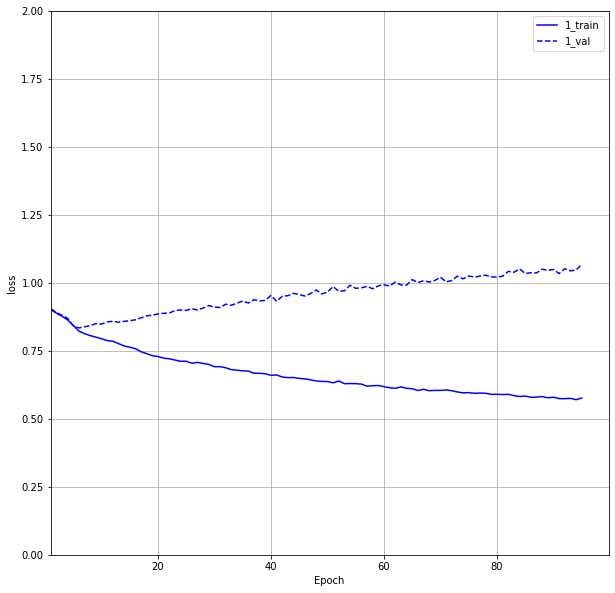

In [ ]:
plotter(sen_histories, ylim=[0.0, 2], metric = 'loss')

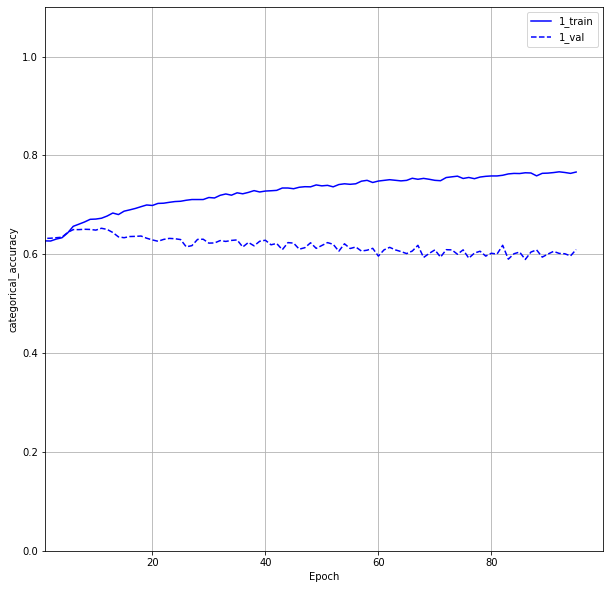

In [ ]:
plotter(sen_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

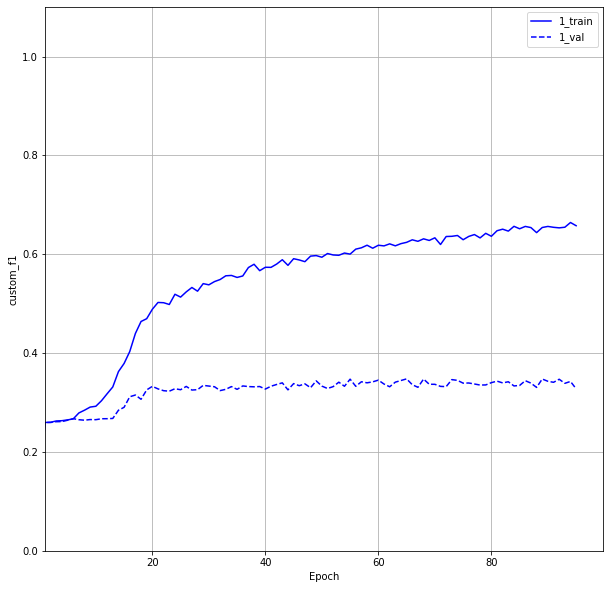

In [ ]:
plotter(sen_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:
predictions = model_itr.predict(sen_x_val)
predicted_classes = np.argmax(predictions, axis=1)

predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(deencodeSen[class_lab])


In [ ]:
from sklearn.metrics import classification_report
# report = classification_report(sen_val['airline_sentiment'], predicted_labs)
# print(metrics.classification_report(y_test_labs,predicted_labs))

In [ ]:
# plot_confusion_matrix(sen_val['airline_sentiment'], predicted_labs)

In [ ]:
# model_itr.save("sentimentMod")

## Transfer Model

In [ ]:

model_cell = tf.keras.models.clone_model(model_itr)

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

#New model based on CT learning rate
# trans_Learning_Rate = K.eval(model_ct.optimizer.lr)

model_itr = Sequential()
model_itr.add(embedding_layer_TL)
for layer in model_cell.layers[1:2]:
  model_itr.add(layer)




model_itr.add(Dense(4, activation='softmax'))

model_itr.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[custom_f1,'categorical_accuracy'])


model_itr.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 55, 50)            572650    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 132       
Total params: 583,406
Trainable params: 10,756
Non-trainable params: 572,650
_________________________________________________________________


In [ ]:
model_itr.compile(loss='categorical_crossentropy', optimizer='adam', metrics= [custom_f1,'categorical_accuracy'])


In [ ]:
m_histories['with__Pretrain_TL'] =  model_itr.fit(x_train, y_train, batch_size=1024,
                                                   epochs=EPOCH, validation_data=(x_val, y_val),
                                                   callbacks=get_callbacks('models/no_TL'),
                                                   verbose=1,
                                                   class_weight = class_weights)

Epoch 1/120
6/6 [==============================] - 4s 274ms/step - loss: 1.4063 - custom_f1: 9.0580e-04 - categorical_accuracy: 0.1428 - val_loss: 1.3826 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2227
Epoch 2/120
6/6 [==============================] - 1s 215ms/step - loss: 1.3704 - custom_f1: 0.0000e+00 - categorical_accuracy: 0.2413 - val_loss: 1.3894 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.2622
Epoch 3/120
6/6 [==============================] - 1s 207ms/step - loss: 1.3655 - custom_f1: 0.0015 - categorical_accuracy: 0.2723 - val_loss: 1.3762 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.3004
Epoch 4/120
6/6 [==============================] - 1s 202ms/step - loss: 1.3572 - custom_f1: 0.0040 - categorical_accuracy: 0.2998 - val_loss: 1.3575 - val_custom_f1: 0.0000e+00 - val_categorical_accuracy: 0.3267
Epoch 5/120
6/6 [==============================] - 1s 187ms/step - loss: 1.3443 - custom_f1: 0.0068 - categorical_accuracy: 0.3132 - val_los

In [ ]:
model_itr.save("/saved_model/8")

INFO:tensorflow:Assets written to: /saved_model/8/assets


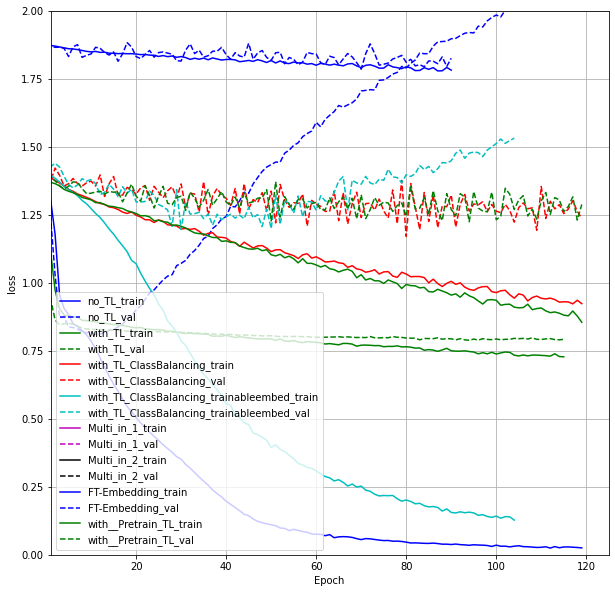

In [ ]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

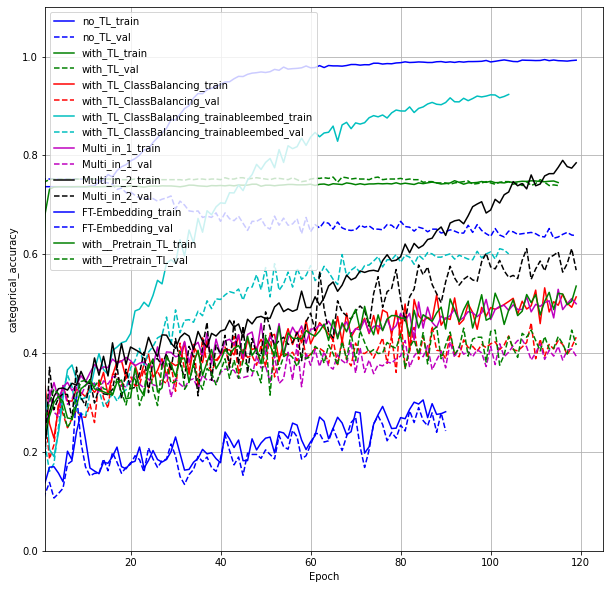

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

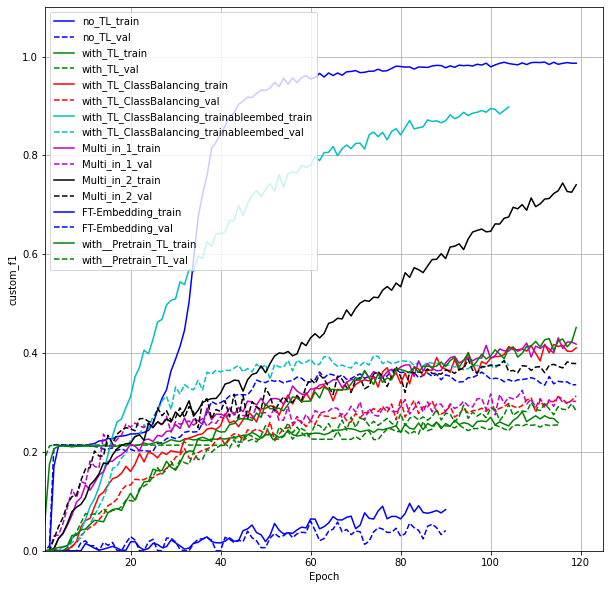

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1')

In [ ]:
predictions = model_itr.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)

predicted_labs = []

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])


In [ ]:
report = metrics.classification_report(y_val_labs,predicted_labs, output_dict = True)
modelResults['M7'] = report

print(metrics.classification_report(y_val_labs,predicted_labs))

              precision    recall  f1-score   support

     comment       0.77      0.36      0.49       571
        deny       0.07      0.16      0.10        61
       query       0.07      0.26      0.11        50
     support       0.12      0.26      0.16        77

    accuracy                           0.33       759
   macro avg       0.26      0.26      0.22       759
weighted avg       0.60      0.33      0.40       759



Confusion matrix, without normalization


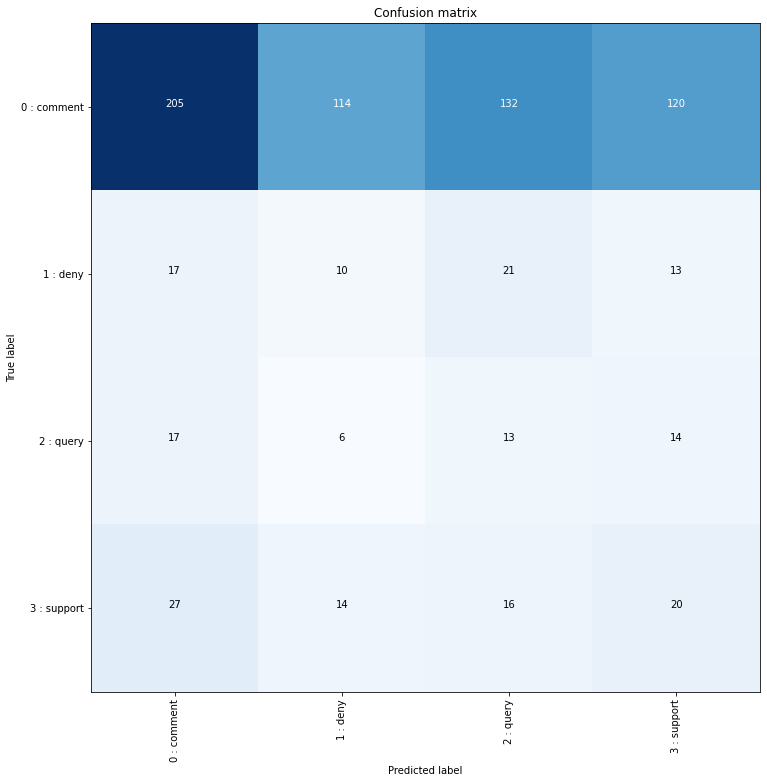

In [ ]:
plot_confusion_matrix(y_val_labs,predicted_labs)

In [ ]:
report

{'accuracy': 0.32674571805006586,
 'comment': {'f1-score': 0.4898446833930705,
  'precision': 0.7706766917293233,
  'recall': 0.35901926444833626,
  'support': 571},
 'deny': {'f1-score': 0.0975609756097561,
  'precision': 0.06944444444444445,
  'recall': 0.16393442622950818,
  'support': 61},
 'macro avg': {'f1-score': 0.21585226268739405,
  'precision': 0.25782754666106383,
  'recall': 0.260673487604526,
  'support': 759},
 'query': {'f1-score': 0.1120689655172414,
  'precision': 0.07142857142857142,
  'recall': 0.26,
  'support': 50},
 'support': {'f1-score': 0.16393442622950818,
  'precision': 0.11976047904191617,
  'recall': 0.2597402597402597,
  'support': 77},
 'weighted avg': {'f1-score': 0.40036750042842245,
  'precision': 0.602220668703835,
  'recall': 0.32674571805006586,
  'support': 759}}

# Evaluate



# Macro Analysis


In [ ]:


models = {"Mod1" : load_model('/saved_model/1', custom_objects={'custom_f1': custom_f1}),
          "Mod2" : load_model('/saved_model/2', custom_objects={'custom_f1': custom_f1}),
          "Mod3" : load_model('/saved_model/3', custom_objects={'custom_f1': custom_f1}),
          "Mod4" : load_model('/saved_model/4', custom_objects={'custom_f1': custom_f1}),
          "Mod5" : load_model('/saved_model/5', custom_objects={'custom_f1': custom_f1}),
          "Mod6" : load_model('/saved_model/6', custom_objects={'custom_f1': custom_f1}),
          "Mod8" : load_model('/saved_model/8', custom_objects={'custom_f1': custom_f1}),
          }

In [ ]:
classMetricsY1 = pd.DataFrame(columns=['modelName', 'type', 'metric', 'value'])
keys_to_extract = ["comment", "deny", "macro avg", "query", "support", "weighted avg" ]


for name, modelx in models.items():
  # print(name)
  if name == "Mod5" or name == "Mod6":
    predictions = modelx.predict([x_test_source, x_test_reply])
  else:
    predictions = modelx.predict(x_test)
  
  predicted_classes = np.argmax(predictions, axis=1)

  predicted_labs = [] 

  for class_lab in predicted_classes:
    predicted_labs.append(decode[class_lab])

  metricWeight = 'macro avg'

  report = metrics.classification_report(y_test_labs,predicted_labs, output_dict = True) 
 



  a_subset = {key: report[key] for key in keys_to_extract}

  for rtype, ritem in a_subset.items():
    for metric, value in a_subset[rtype].items():
      classMetricsY1 = classMetricsY1.append({'modelName': name,'type': rtype, 'metric': metric,'value': value}, ignore_index=True)


classMetricsY1.to_csv("results.csv")

# from google.colab import files
# files.download("results.csv")
classMetricsY1

modelName          type     metric       value
0        Mod1       comment  precision    0.749141
1        Mod1       comment     recall    0.766257
2        Mod1       comment   f1-score    0.757602
3        Mod1       comment    support  569.000000
4        Mod1          deny  precision    0.021277
..        ...           ...        ...         ...
163      Mod8       support    support   84.000000
164      Mod8  weighted avg  precision    0.572919
165      Mod8  weighted avg     recall    0.317523
166      Mod8  weighted avg   f1-score    0.383339
167      Mod8  weighted avg    support  759.000000

[168 rows x 4 columns]

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


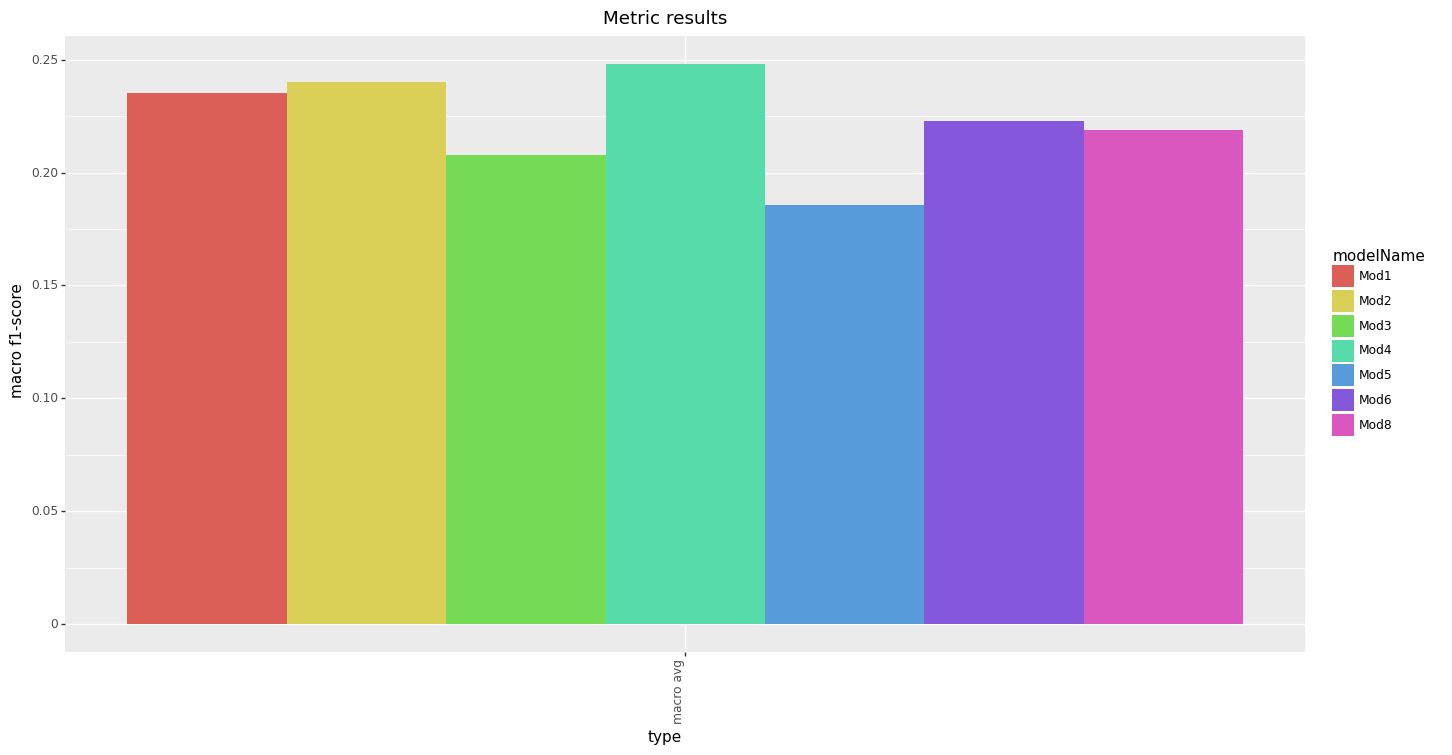

<ggplot: (8740594750169)>

In [ ]:
# !pip install plotnine
from plotnine import *

metricType = 'f1-score'

display= classMetricsY1[classMetricsY1.type == "macro avg"]
display
(
    ggplot(display[display.metric == metricType])  # What data to use
    + aes(x="type", y="value", fill = "modelName")  
    + geom_bar(stat="identity", position = "dodge")  
    + labs(x ="type" , y = "macro " + metricType, title = "Metric results") +
    theme(axis_text_x=element_text(rotation=90, hjust=1),figure_size=(16, 8))

)

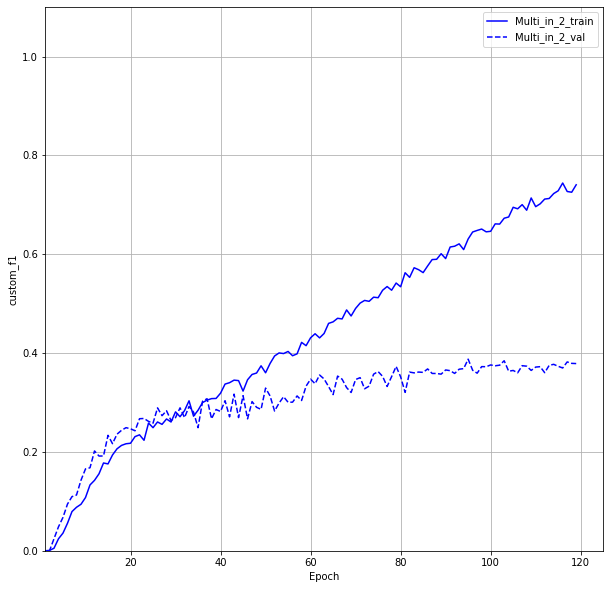

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'custom_f1', Name = "Multi_in_2")

# Independent Data


In [ ]:
!cp /content/drive/'My Drive'/COSC2779/Assignment2/'independent.csv.zip' . 
!unzip -q -o 'independent.csv.zip'


In [ ]:
!ls

 1.hd5				    results.csv
 database.sqlite		    Rumour_data
 drive				    sample_data
 glove.twitter.27B.50d.txt	    saved_model
 independent.csv		   'sentiment analsysis.zip'
 independent.csv.zip		    sentimentMod
 __MACOSX			    Tweets.csv
 multi_input_and_output_model.png


In [ ]:
independent = pd.read_csv("independent.csv")
independent.dropna(subset= ["Text"], inplace= True)
independent

Type        Msg_ID  ...   Topic    Class
0   Source  5.810000e+17  ...  gladys       -1
1    Reply  1.000000e+00  ...     NaN     deny
2    Reply  1.000000e+00  ...     NaN  support
3    Reply  1.000000e+00  ...     NaN    query
4    Reply  1.000000e+00  ...     NaN     deny
5    Reply  1.000000e+00  ...     NaN  comment
6    Reply  1.000000e+00  ...     NaN  support
7    Reply  1.000000e+00  ...     NaN  comment
8    Reply  1.000000e+00  ...     NaN  comment
9    Reply  1.000000e+00  ...     NaN  comment
10   Reply  1.000000e+00  ...     NaN  comment
11   Reply  1.000000e+00  ...     NaN  comment
12   Reply  1.000000e+00  ...     NaN  comment
13   Reply  1.000000e+00  ...     NaN  comment
14   Reply  1.000000e+00  ...     NaN  comment
15   Reply  1.000000e+00  ...     NaN  comment
16   Reply  1.000000e+00  ...     NaN  comment
17   Reply  1.000000e+00  ...     NaN     deny
18   Reply  1.000000e+00  ...     NaN  comment
19   Reply  1.000000e+00  ...     NaN  comment
20   Reply  1.000000e+00  ...     NaN  support
21   Reply  1.000000e+00  ...     NaN     deny
22   Reply  1.000000e+00  ...     NaN    query

[23 rows x 6 columns]

In [ ]:
ind_responses = independent.iloc[0:0]
ind_responses['Source_text'] = ""

SourceTxt = ""
for i, txt_type in enumerate(independent['Type']):
  # print(i,text_type)
  row = independent.iloc[i]
  
  if txt_type == "Source":
    
    SourceTxt = independent.iloc[i][3]
  if txt_type == "Reply":
    row.at['Source_text'] = SourceTxt
    ind_responses = ind_responses.append(row)

    
  
ind_responses

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Type  Msg_ID  ...    Class                                        Source_text
1   Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
2   Reply     1.0  ...  support  This story asserts that Gladys Berejiklian and...
3   Reply     1.0  ...    query  This story asserts that Gladys Berejiklian and...
4   Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
5   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
6   Reply     1.0  ...  support  This story asserts that Gladys Berejiklian and...
7   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
8   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
9   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
10  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
11  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
12  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
13  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
14  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
15  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
16  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
17  Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
18  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
19  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
20  Reply     1.0  ...  support  This story asserts that Gladys Berejiklian and...
21  Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
22  Reply     1.0  ...    query  This story asserts that Gladys Berejiklian and...

[22 rows x 7 columns]

In [ ]:
clean_ind = ind_responses
clean_ind['Text'] = masterCleaning(ind_responses['Text'])
clean_ind['Source_text'] = masterCleaning(ind_responses['Source_text'])
clean_ind

Type  Msg_ID  ...    Class                                        Source_text
1   Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
2   Reply     1.0  ...  support  This story asserts that Gladys Berejiklian and...
3   Reply     1.0  ...    query  This story asserts that Gladys Berejiklian and...
4   Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
5   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
6   Reply     1.0  ...  support  This story asserts that Gladys Berejiklian and...
7   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
8   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
9   Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
10  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
11  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
12  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
13  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
14  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
15  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
16  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
17  Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
18  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
19  Reply     1.0  ...  comment  This story asserts that Gladys Berejiklian and...
20  Reply     1.0  ...  support  This story asserts that Gladys Berejiklian and...
21  Reply     1.0  ...     deny  This story asserts that Gladys Berejiklian and...
22  Reply     1.0  ...    query  This story asserts that Gladys Berejiklian and...

[22 rows x 7 columns]

In [ ]:




clean_ind["Class_num"] = clean_ind["Class"].apply(lambda x: encode[x])
clean_ind['Text'] = clean_ind['Text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopWords2))
clean_ind['Source_text'] = clean_ind['Source_text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopWords2))

clean_ind['Text'] = clean_ind['Text'].apply(lambda words: " ".join(word.lower() for word in words.split() if len(word) >1))
clean_ind['Source_text'] = clean_ind['Source_text'].apply(lambda words: " ".join(word.lower() for word in words.split() if len(word) >1))


clean_ind = clean_ind[clean_ind['Source_text'] != ""]
clean_ind = clean_ind[clean_ind['Text'] != ""]


clean_ind['Combined_text'] = "src " + clean_ind['Source_text']  + " rply " + clean_ind['Text'] 
clean_ind.drop_duplicates(subset = ['Combined_text'], inplace = True)


clean_ind

Type  Msg_ID  ...  Class_num                                      Combined_text
1   Reply     1.0  ...          1  src this story asserts gladys berejiklian crew...
2   Reply     1.0  ...          3  src this story asserts gladys berejiklian crew...
3   Reply     1.0  ...          2  src this story asserts gladys berejiklian crew...
4   Reply     1.0  ...          1  src this story asserts gladys berejiklian crew...
5   Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
6   Reply     1.0  ...          3  src this story asserts gladys berejiklian crew...
7   Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
8   Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
9   Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
10  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
11  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
12  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
13  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
14  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
15  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
16  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
17  Reply     1.0  ...          1  src this story asserts gladys berejiklian crew...
18  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
19  Reply     1.0  ...          0  src this story asserts gladys berejiklian crew...
20  Reply     1.0  ...          3  src this story asserts gladys berejiklian crew...
21  Reply     1.0  ...          1  src this story asserts gladys berejiklian crew...
22  Reply     1.0  ...          2  src this story asserts gladys berejiklian crew...

[22 rows x 9 columns]

In [ ]:
ind_text_lines_combined, ind_text_lines_source, ind_text_lines_reply = cleanse_tokenize(clean_ind)

token
token
token


In [ ]:
word_index

{'src': 1,
 'rply': 2,
 'police': 3,
 'ferguson': 4,
 'the': 5,
 'sydney': 6,
 'people': 7,
 'paris': 8,
 'hostage': 9,
 'breaking': 10,
 'charliehebdo': 11,
 'killed': 12,
 'shot': 13,
 'get': 14,
 'one': 15,
 'hostages': 16,
 'robbery': 17,
 'says': 18,
 'amp': 19,
 'ottawa': 20,
 'would': 21,
 'sydneysiege': 22,
 'shooting': 23,
 'like': 24,
 'hillary': 25,
 'parliament': 26,
 'news': 27,
 'dead': 28,
 'attack': 29,
 'mike': 30,
 'cafe': 31,
 'still': 32,
 'video': 33,
 'reports': 34,
 'soldier': 35,
 'via': 36,
 'dont': 37,
 'war': 38,
 'true': 39,
 'say': 40,
 'suspect': 41,
 'this': 42,
 'french': 43,
 'immigrants': 44,
 'hill': 45,
 'know': 46,
 'memorial': 47,
 'if': 48,
 'gunman': 49,
 'us': 50,
 'knows': 51,
 'brexit': 52,
 'it': 53,
 'brown': 54,
 'time': 55,
 'germanwings': 56,
 'help': 57,
 'said': 58,
 'day': 59,
 'isis': 60,
 'go': 61,
 'store': 62,
 'national': 63,
 'suspects': 64,
 'channel': 65,
 'think': 66,
 'god': 67,
 'least': 68,
 'man': 69,
 'held': 70,
 'im': 7

In [ ]:
for line in ind_text_lines_combined:
  for word in line:
    if word not in word_index:
      word_index[word] = len(word_index)

In [ ]:
word_index['asserts']

11452

In [ ]:
 #The combined word index is used for embedding and max_length
x, word_indexnone, max_length = gen_padding(ind_text_lines_combined)



ind_x_src = pad_sequences(translateToSequence(ind_text_lines_source), maxlen=max_length, padding='pre')
ind_x_rply = pad_sequences(translateToSequence(ind_text_lines_reply), maxlen=max_length, padding='pre')

ind_y =  clean_ind['Class_num'].values

ind_y = pd.get_dummies(ind_y)

ind_y

unique tokens - 224
vocab_size - 225


0  1  2  3
0   0  1  0  0
1   0  0  0  1
2   0  0  1  0
3   0  1  0  0
4   1  0  0  0
5   0  0  0  1
6   1  0  0  0
7   1  0  0  0
8   1  0  0  0
9   1  0  0  0
10  1  0  0  0
11  1  0  0  0
12  1  0  0  0
13  1  0  0  0
14  1  0  0  0
15  1  0  0  0
16  0  1  0  0
17  1  0  0  0
18  1  0  0  0
19  0  0  0  1
20  0  1  0  0
21  0  0  1  0

In [ ]:
finalModel = keras.models.load_model("/saved_model/6", custom_objects={'custom_f1': custom_f1} )

predictions =finalModel.predict([ind_x_src,ind_x_rply ])
  
predicted_classes = np.argmax(predictions, axis=1)

predicted_labs = [] 

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])

metricWeight = 'macro avg'

report = metrics.classification_report(clean_ind['Class'],predicted_labs) 
print(report)

              precision    recall  f1-score   support

     comment       0.68      1.00      0.81        13
        deny       0.00      0.00      0.00         4
       query       1.00      1.00      1.00         2
     support       1.00      0.33      0.50         3

    accuracy                           0.73        22
   macro avg       0.67      0.58      0.58        22
weighted avg       0.63      0.73      0.64        22



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clean_ind['Predicted'] = predicted_labs
clean_ind

Type  Msg_ID  ...                                      Combined_text Predicted
1   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
2   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
3   Reply     1.0  ...  src this story asserts gladys berejiklian crew...     query
4   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
5   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
6   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
7   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
8   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
9   Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
10  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
11  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
12  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
13  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
14  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
15  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
16  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
17  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
18  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
19  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
20  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   support
21  Reply     1.0  ...  src this story asserts gladys berejiklian crew...   comment
22  Reply     1.0  ...  src this story asserts gladys berejiklian crew...     query

[22 rows x 10 columns]

In [ ]:
predictions =finalModel.predict([x_test_source,x_test_reply ])
  
predicted_classes = np.argmax(predictions, axis=1)

predicted_labs = [] 

for class_lab in predicted_classes:
  predicted_labs.append(decode[class_lab])

metricWeight = 'macro avg'

report = metrics.classification_report(y_test_labs,predicted_labs) 
print(report)

              precision    recall  f1-score   support

     comment       0.75      0.59      0.66       569
        deny       0.03      0.05      0.04        40
       query       0.06      0.08      0.07        66
     support       0.10      0.19      0.13        84

    accuracy                           0.47       759
   macro avg       0.23      0.23      0.22       759
weighted avg       0.58      0.47      0.51       759



In [ ]:
x_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
       3596, 1968, 2244, 3597, 3159, 3598, 1692, 1983, 1799,  800, 1799,
       2756, 2858,  221,  395,    2,  368,  707,  837, 2428, 9888, 3729,
       1520, 2956,  319,  319,   79,  595,  420, 2132,  526, 1890,  307],
      dtype=int32)

In [ ]:
incorrect = []
correct = []
for ind, pred in enumerate(y_test_labs):
  # print(pred, predicted_labs[ind])
  if predicted_labs[ind] != pred:
    # print(ind, pred, predicted_labs[ind])
    incorrect.append(ind)
  if predicted_labs[ind] == pred:
    correct.append(ind)

def translate(sourceText):
  xtranslate = []
  for line in sourceText:
    # print(line)
    innerLines = []
    for word in line:
      if word == 0:
        innerLines.append("")
      else:
        innerLines.append(word_index_reverse[word])

    xtranslate.append(" ".join(str(x) for x in innerLines).lstrip(" "))
  return xtranslate

sourceTranslate = np.array(translate(x_test_source))
replyTranslate = np.array(translate(x_test_reply))



incorrectDF = pd.DataFrame()
incorrectDF['Source'] = sourceTranslate[incorrect]
incorrectDF['Reply'] = replyTranslate[incorrect]
incorrectDF['True'] = np.array(y_test_labs)[incorrect].tolist()
incorrectDF['Pred'] = np.array(predicted_labs)[incorrect].tolist()
incorrectDF

Source  ...     Pred
0    the ferguson police chief basically confirmed ...  ...     deny
1    wtf anyone seen harvey flooding uncovers secre...  ...  comment
2    this soldier died today ottawa war memorial hi...  ...  support
3    and many people arena know underprivileged anyway  ...  support
4    heres police report somehow ferguson cops valu...  ...  comment
..                                                 ...  ...      ...
397  oh so now ferguson police chief says cop didnt...  ...    query
398  if surveillance robbery release stills video f...  ...    query
399            up held hostage sydney lindt cafe siege  ...  support
400   prince playing massey hall tonight promoter says  ...  support
401                       what think hillary suffering  ...  comment

[402 rows x 4 columns]

In [ ]:
sourceTranslate = np.array(translate(x_test_source))
replyTranslate = np.array(translate(x_test_reply))



correctDF = pd.DataFrame()
correctDF['Source'] = sourceTranslate[correct]
correctDF['Reply'] = replyTranslate[correct]
correctDF['True'] = np.array(y_test_labs)[correct].tolist()
correctDF['Pred'] = np.array(predicted_labs)[correct].tolist()
correctDF

Source  ...     Pred
0    repost til financial guru robert kiyosaki auth...  ...  comment
1                     serious man dinosaurs lived time  ...  comment
2    clinton camp delays weather channel ad buy bac...  ...  comment
3    it appears ferguson pd trying assassinate mike...  ...  comment
4    heres police report somehow ferguson cops valu...  ...  comment
..                                                 ...  ...      ...
352  update ferguson police release stills convenie...  ...  comment
353  question ferguson police chief if officer darr...  ...  comment
354  how much truth statement only actually soldier...  ...  comment
355  how many white celebrities caught shoplifting ...  ...  comment
356  police name officer shot ferguson teenager mic...  ...  comment

[357 rows x 4 columns]

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Failure Analysys

## Source text WC

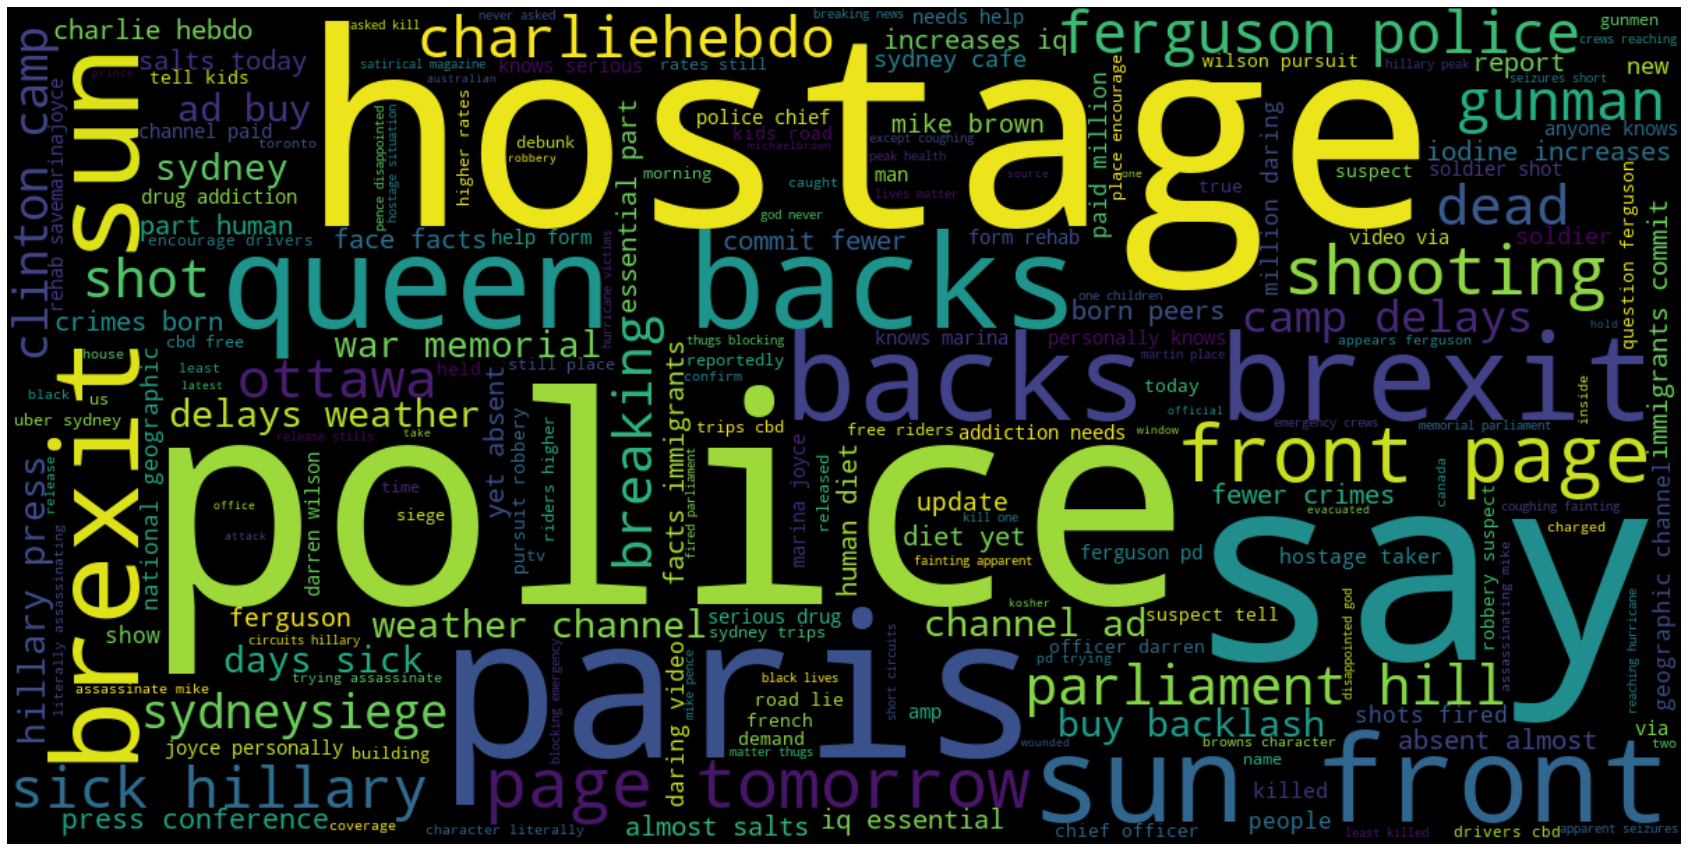

In [ ]:
wordcloud2 = WordCloud( width=1200, height=600).generate(' '.join(correctDF['Source']))
plt.figure(figsize=(30,30))

plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Correct Reply

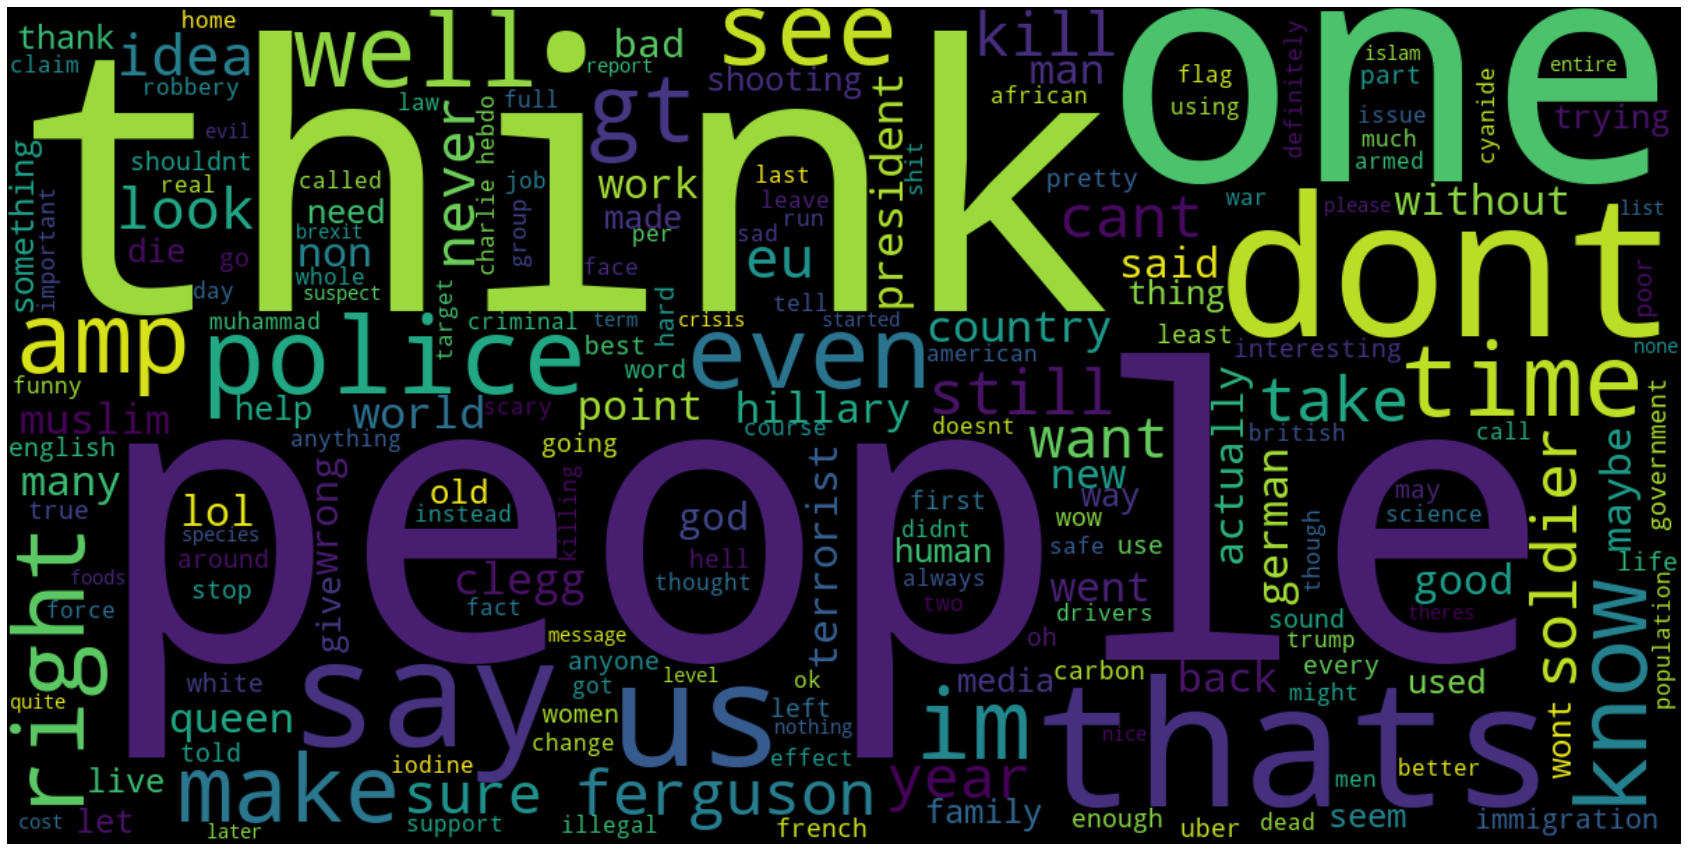

In [ ]:
wordcloud2 = WordCloud( width=1200, height=600).generate(' '.join(correctDF['Reply']))
plt.figure(figsize=(30,30))


plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Incorrect text WC

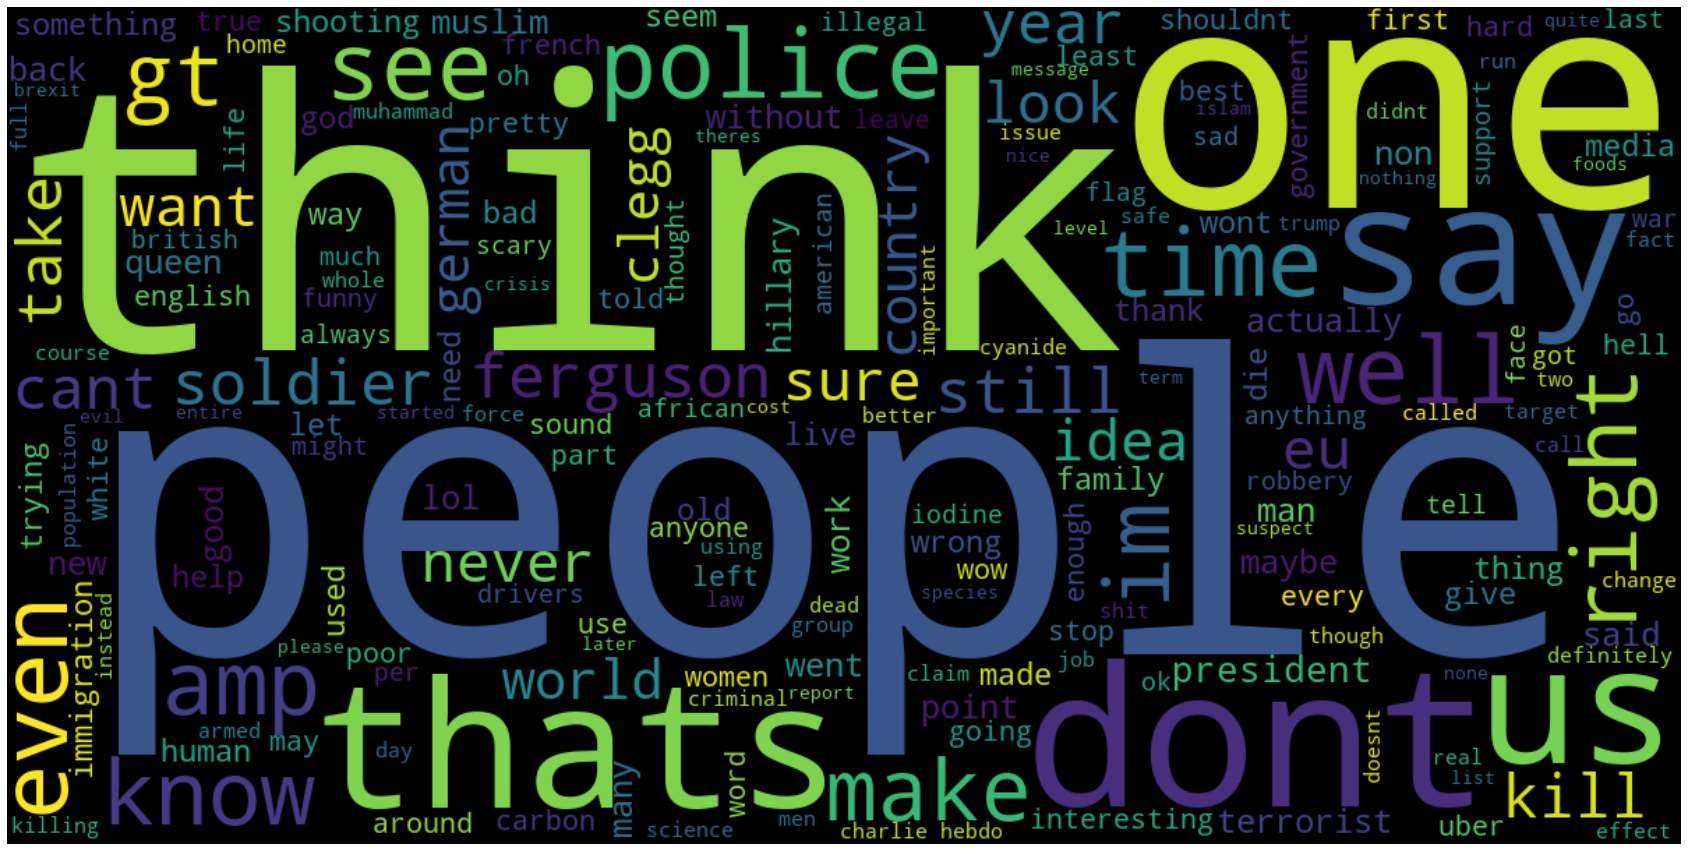

In [ ]:
wordcloud2 = WordCloud(width=1200, height=600).generate(' '.join(incorrectDF['Reply']))
plt.figure(figsize=(30,30))

plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

# Brief Summary 

On the test set, all models performed worse compared to the validation set. It is unclear why this is the case. Most models performed very similarly on the test set but the best, Model6 was selected by its m-f1 performance on the test balancing the effect of over fitting. 

Most of the approach to architecture was designed to reduce over-training which is why adding more complex architecture to each branch was not explored, as increasing the complexity of the model would only decrease overall performance. 

Overall this task was very challenging to achieve a high macro-f1. The biggest challenge was the severe class imbalance with comment being the overall dominant class. The only way I could attempt to ameliorate this was to use class-weighting which would result in a better outcome for the minority classes but severely compromise the predictive ability of comment class. Other possible viable approaches which could have helped would have been to use SMOTE but this would require the words to be embedded prior to generating synthetic samples which would reduce the ability to interpret the model. There was a clear balancing act between overfitting and maximising all metrics, which is why Model 6 being middle of the road macro-f1 was selected for the final model.